keras version 2.2.5
tf version 1.15.0
['old' 'young']
keras version 2.2.5
tf version 1.15.0







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  C:\Users\kuki\PycharmProjects\Mask_RCNN\logs\fibroblast20200519T0140\mask_rcnn_fibroblast_0002.h5






Re-starting from epoch 2
original_image           shape: (128, 128, 3)         min:   31.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max:  326.00000  int32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:   52.00000  max:   77.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  bool
Processing 1 images
image                    shape: (128, 128

Using TensorFlow backend.


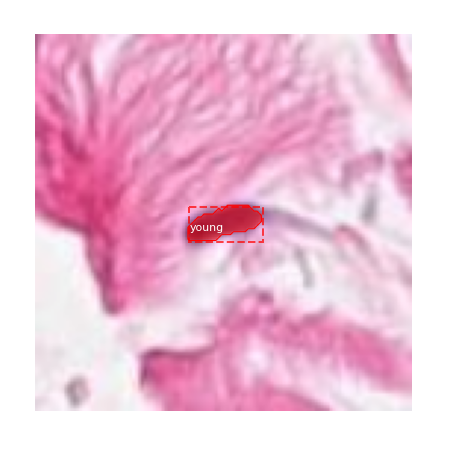

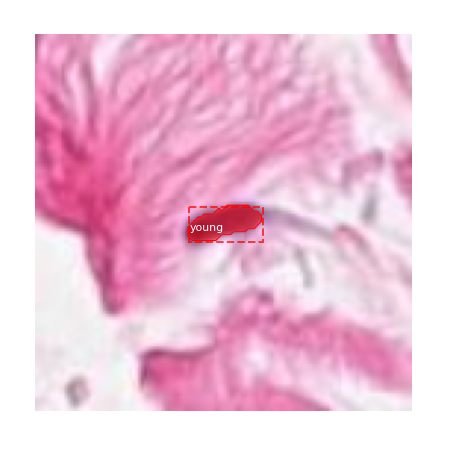

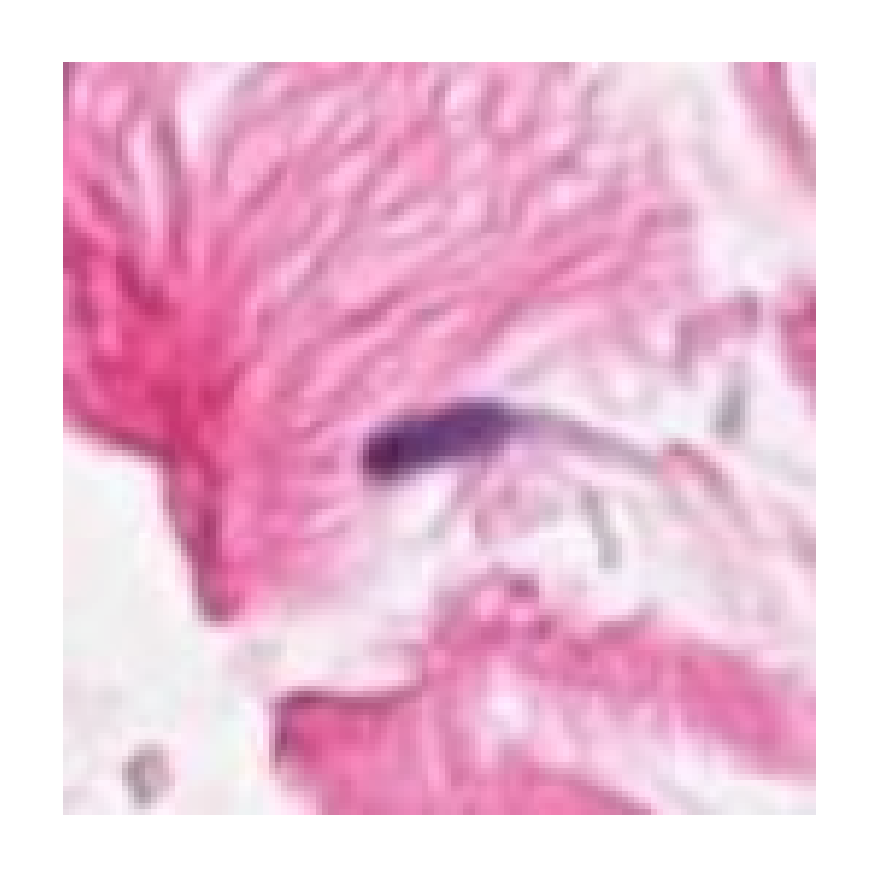

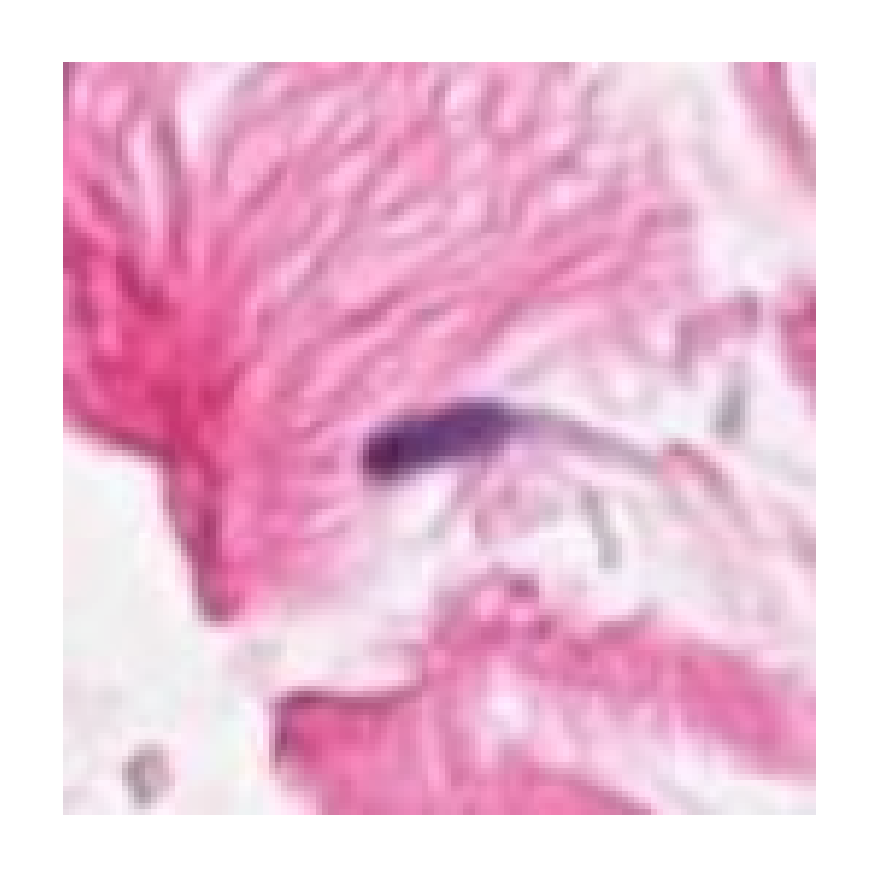

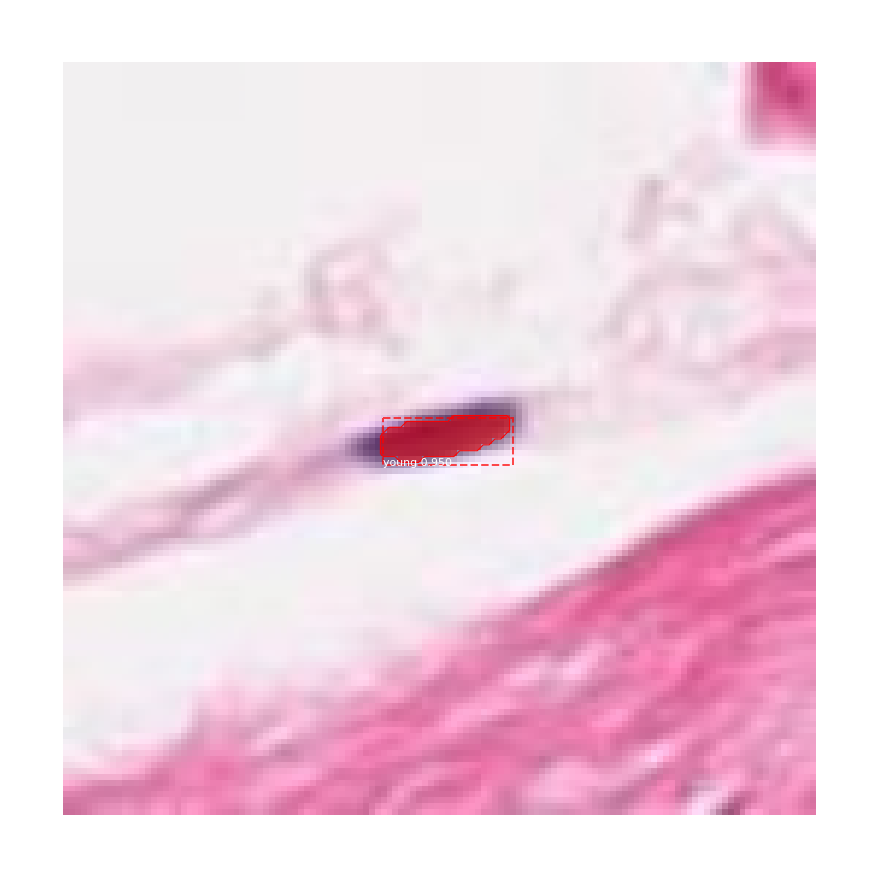

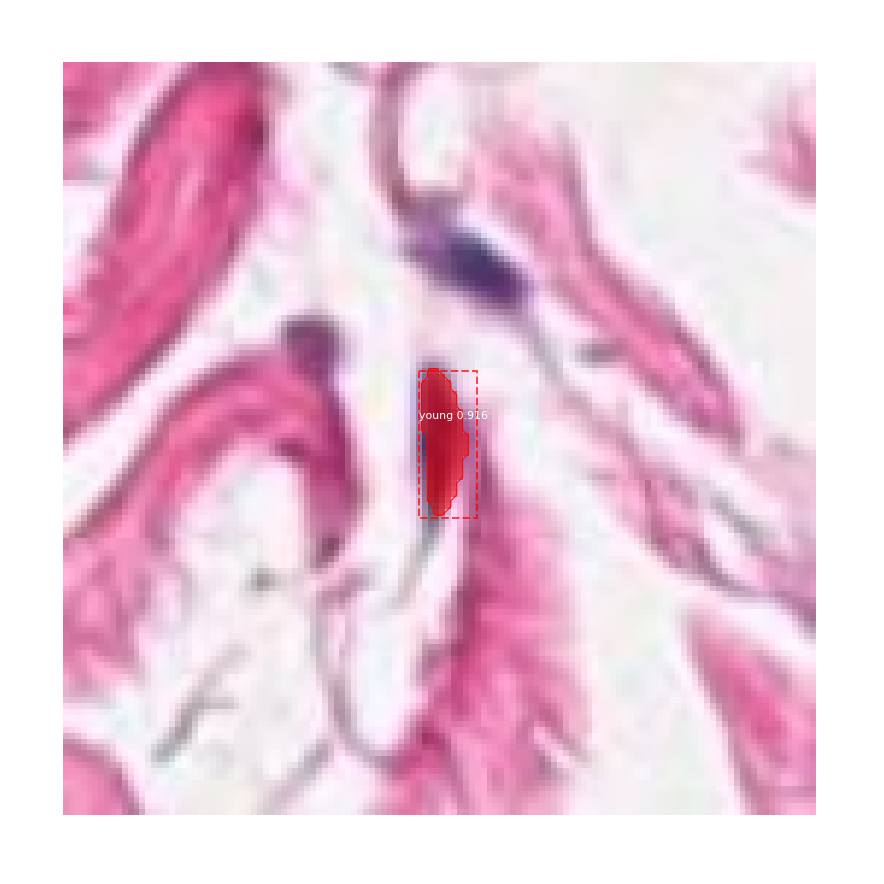

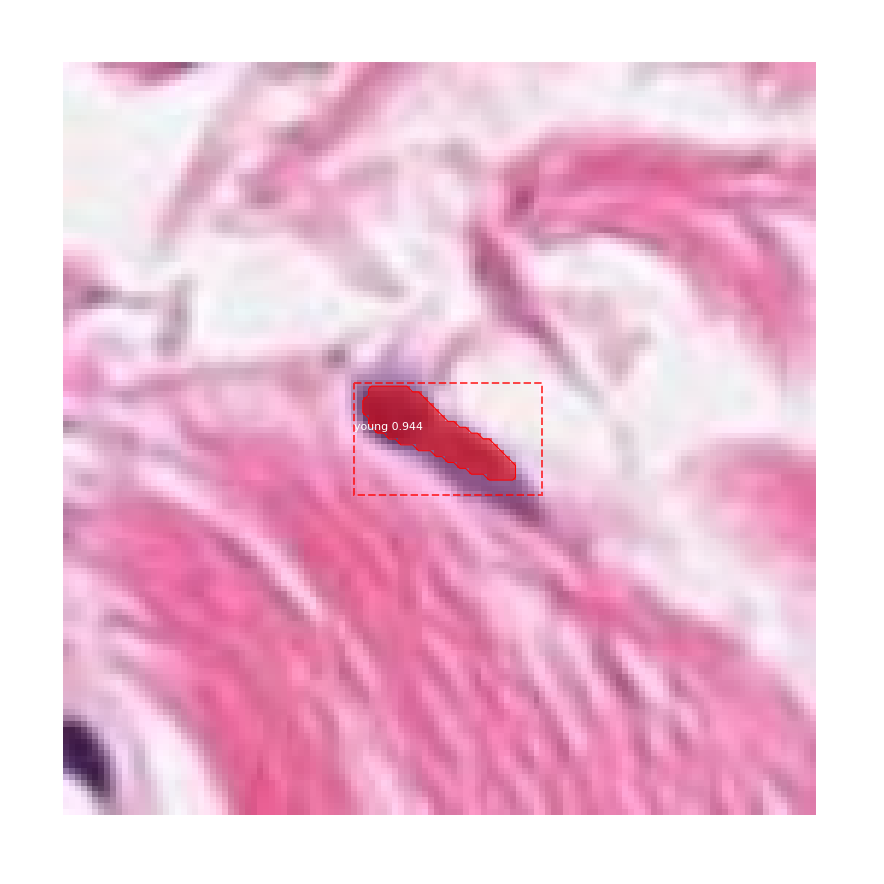

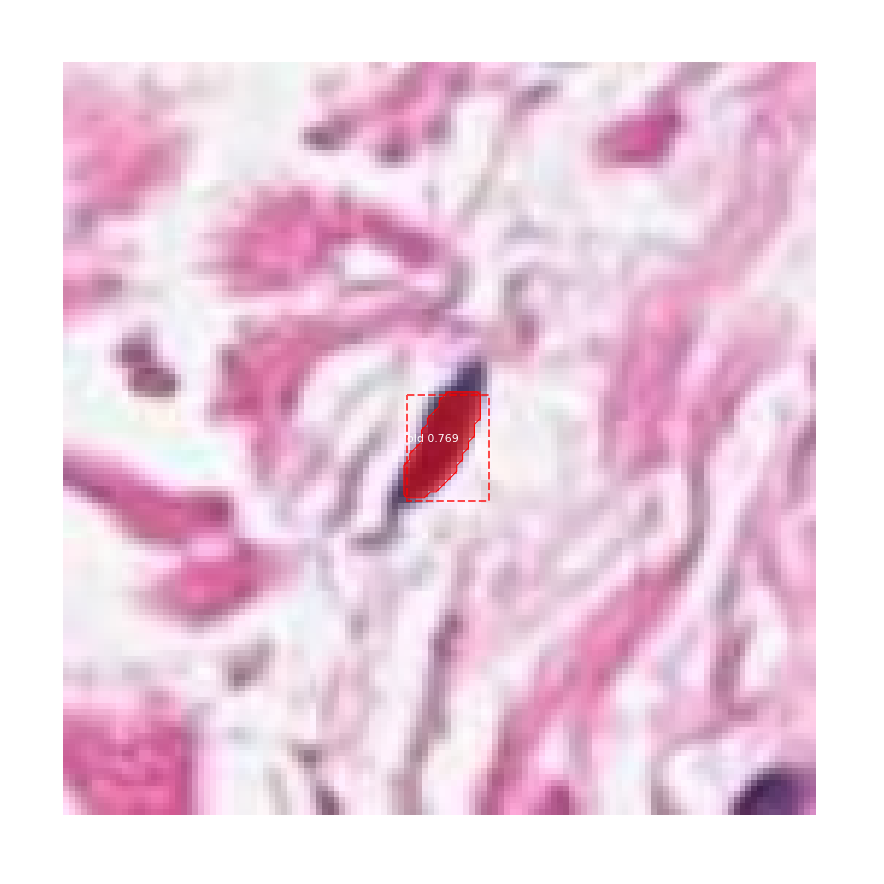

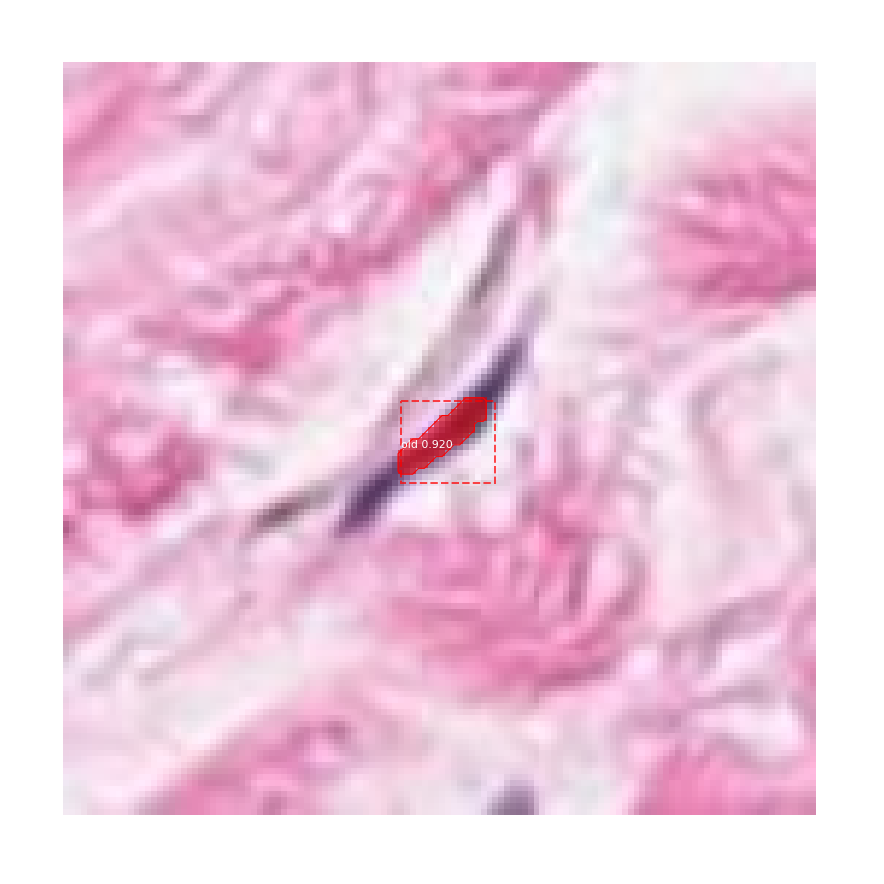

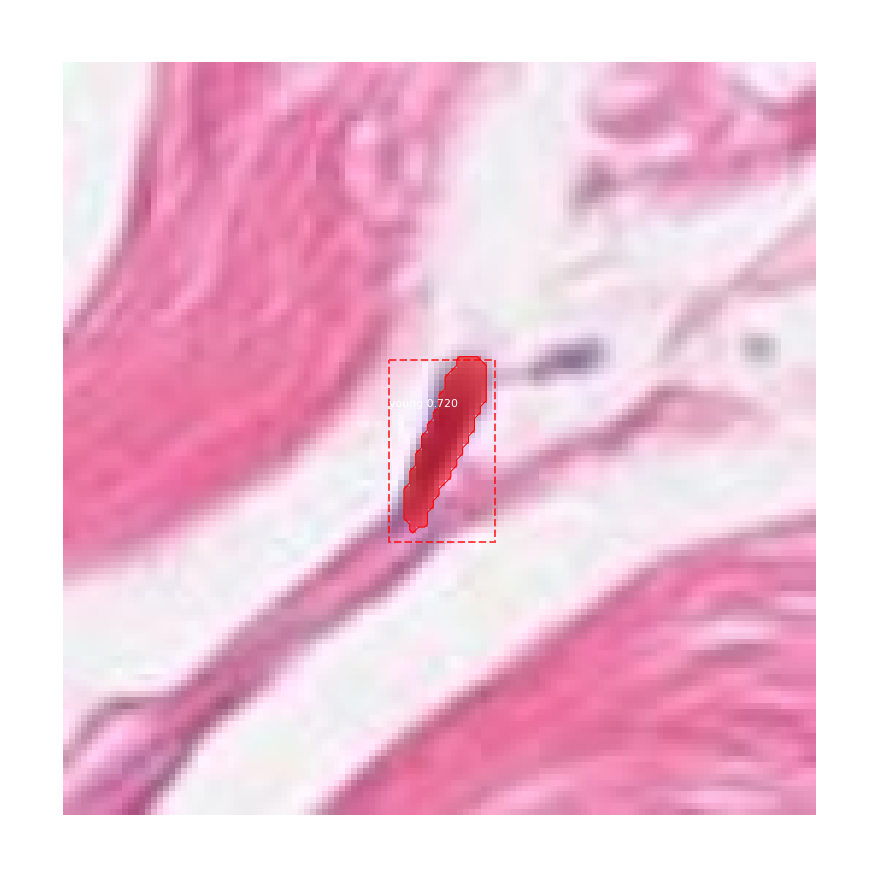

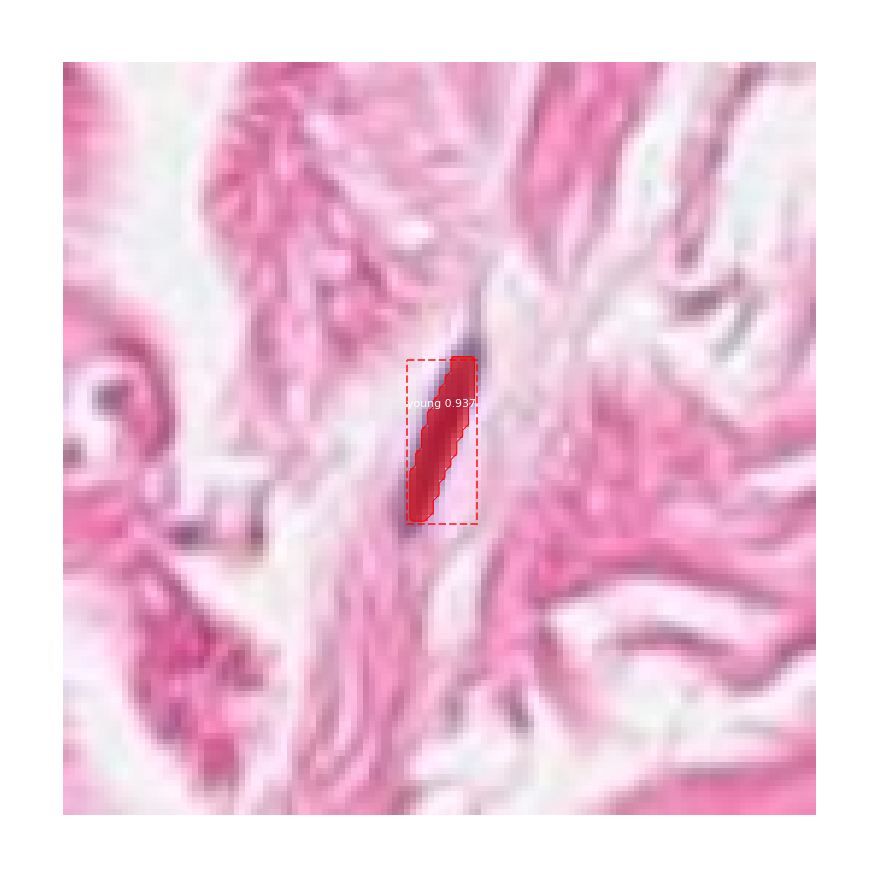

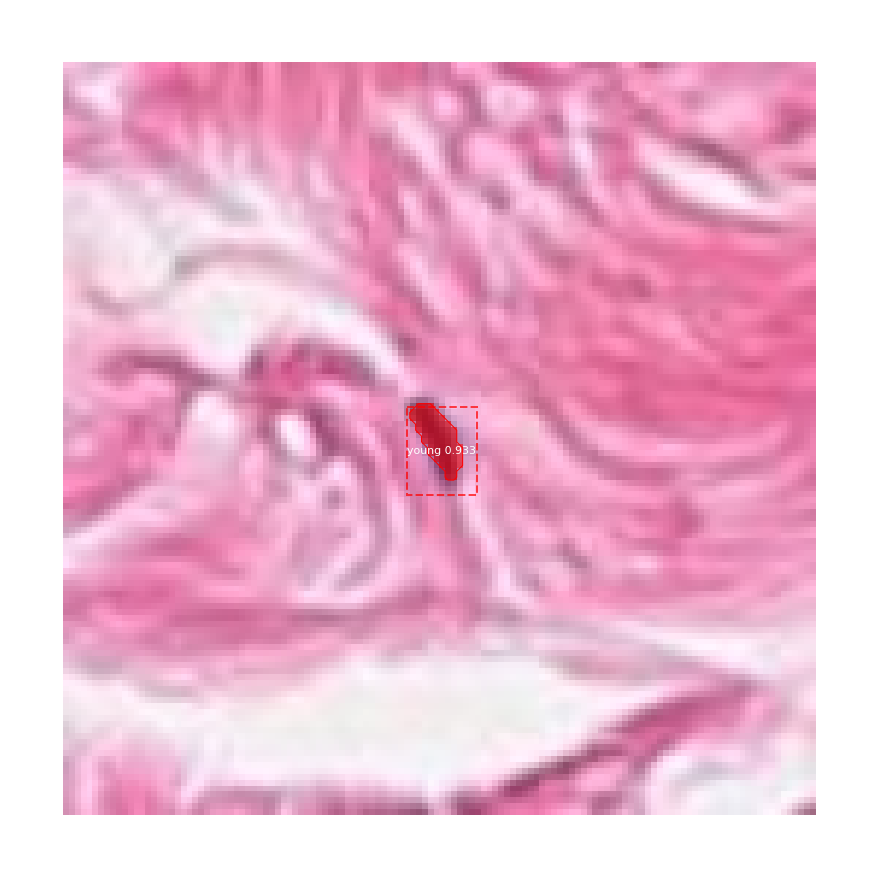

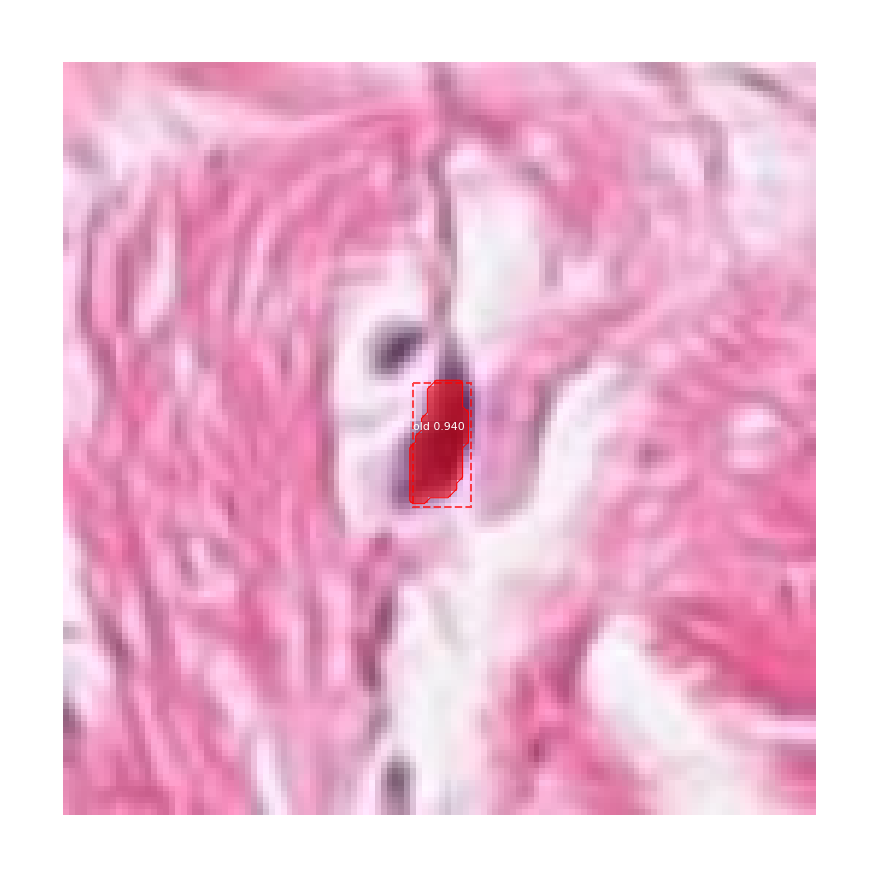

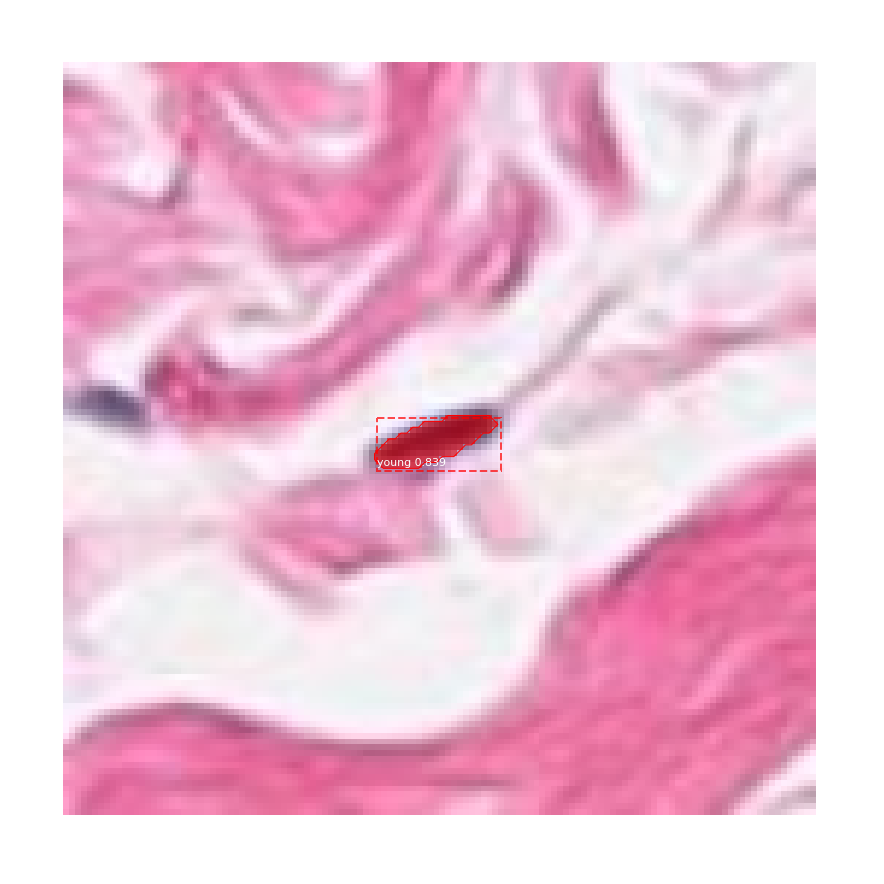

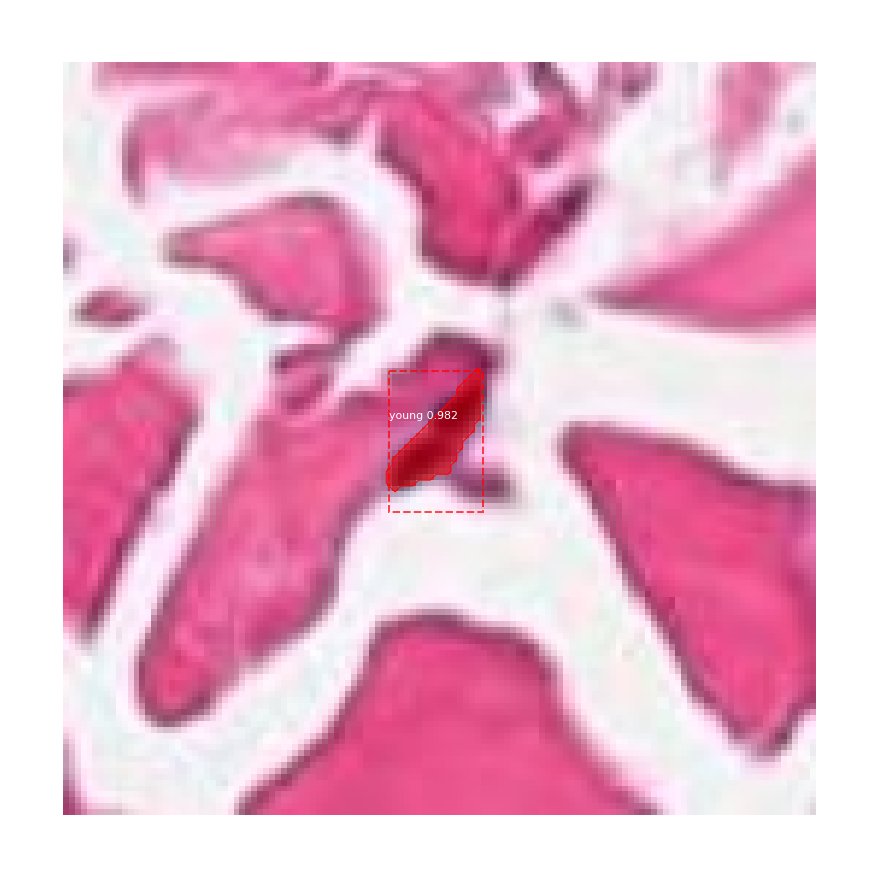

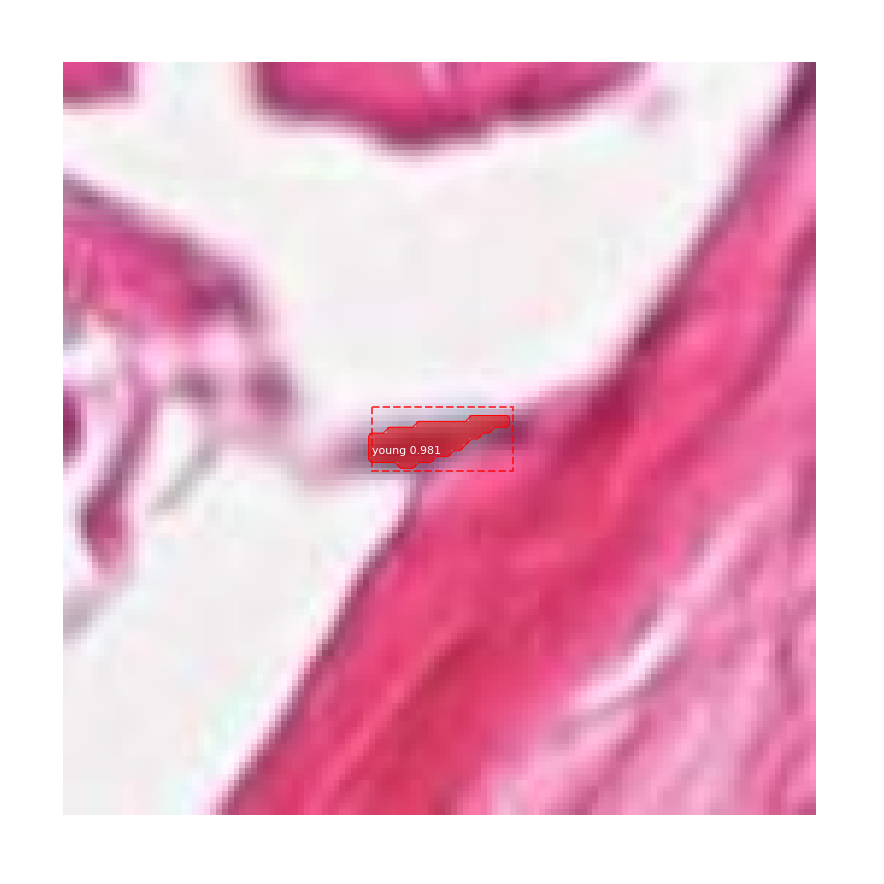

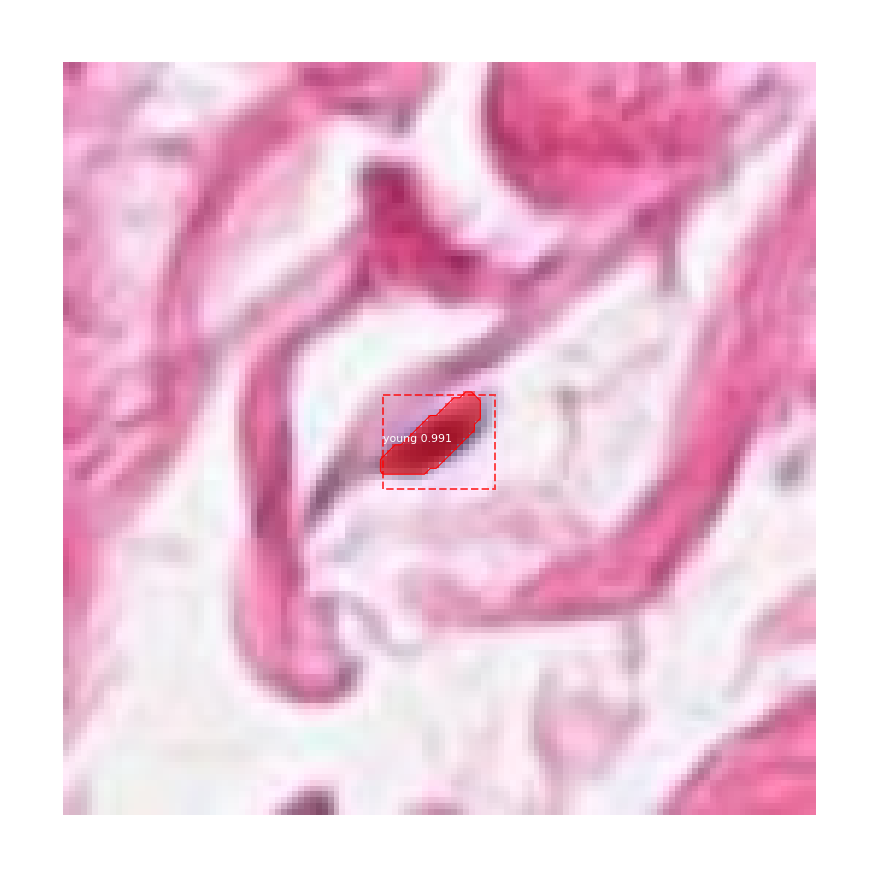

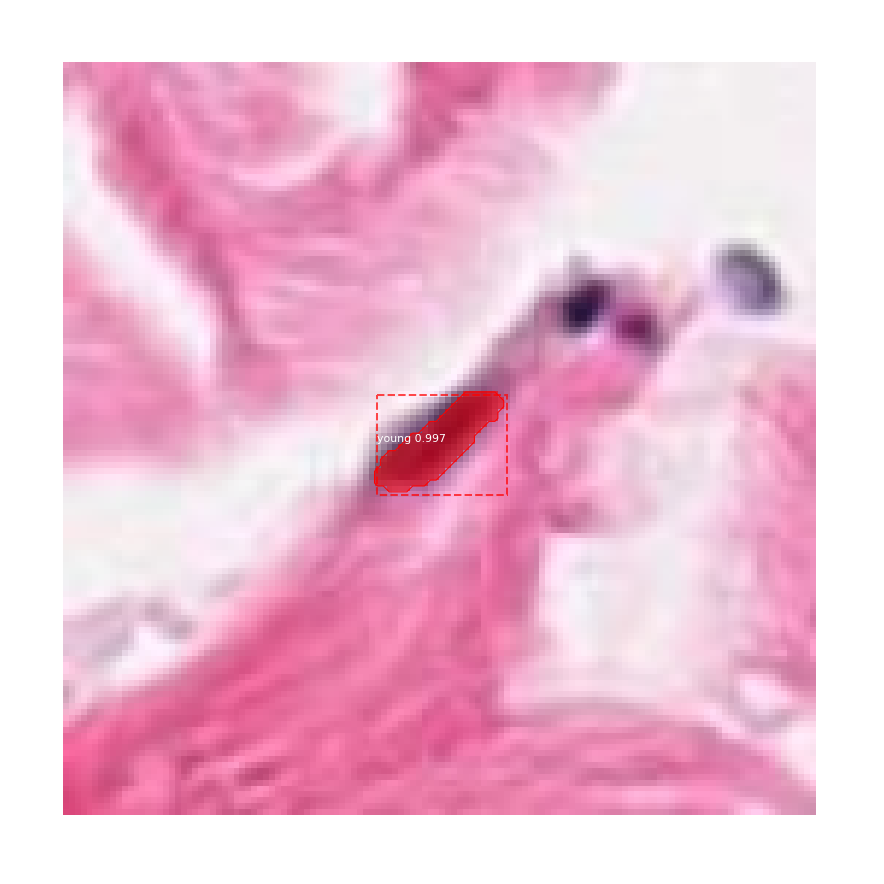

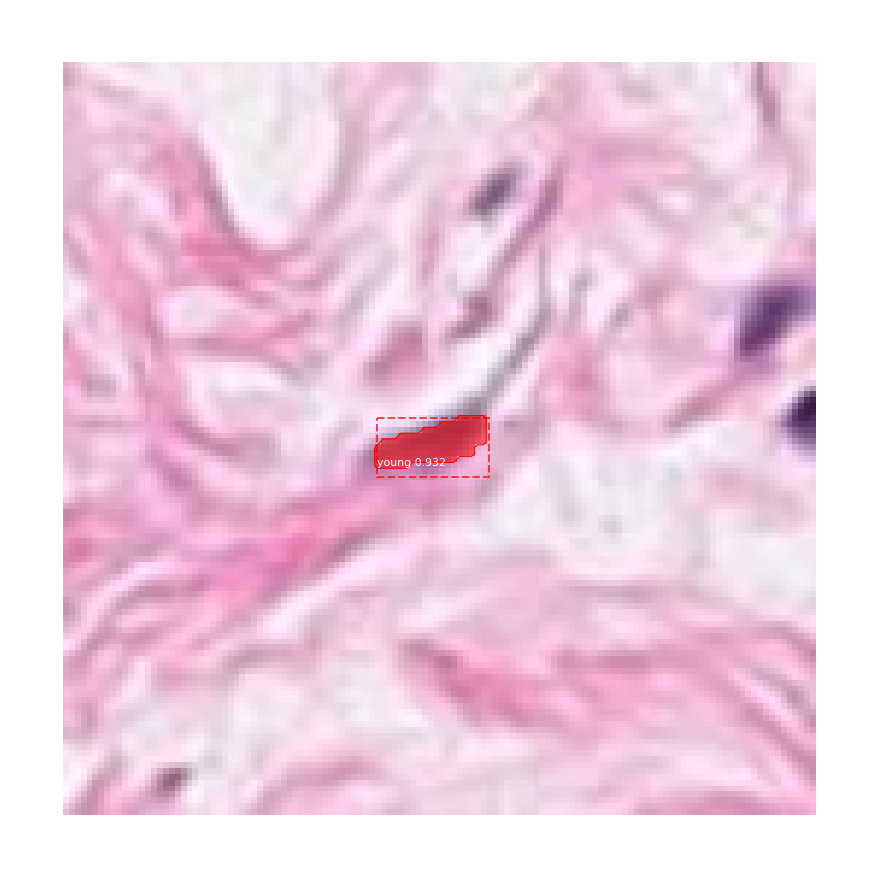

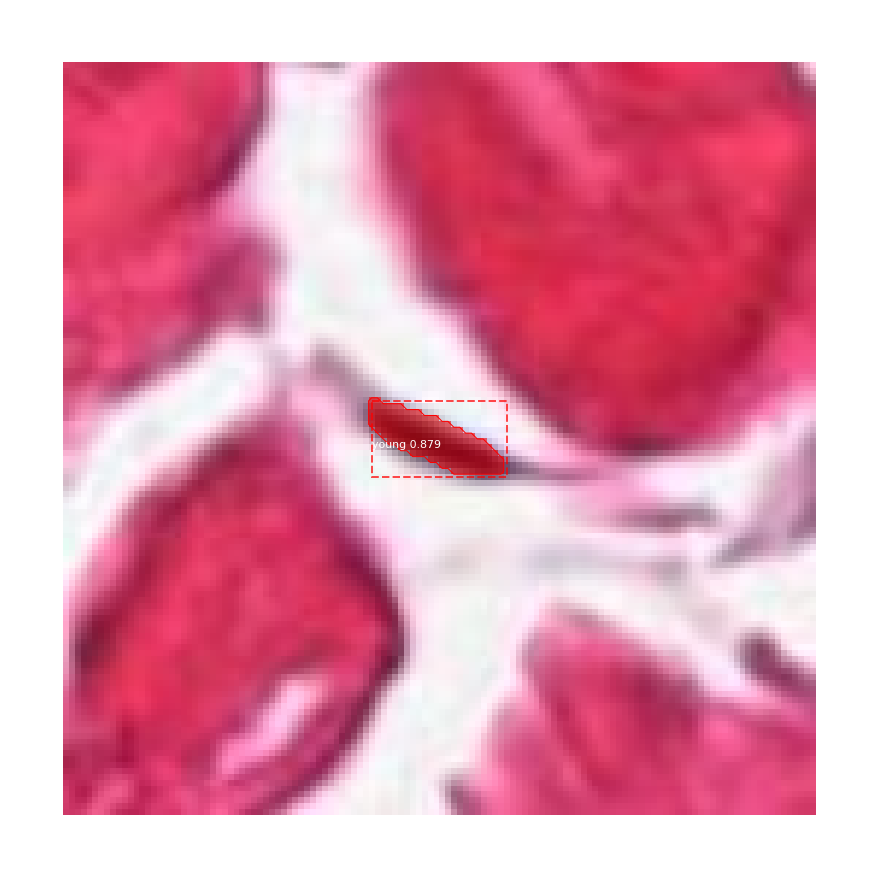

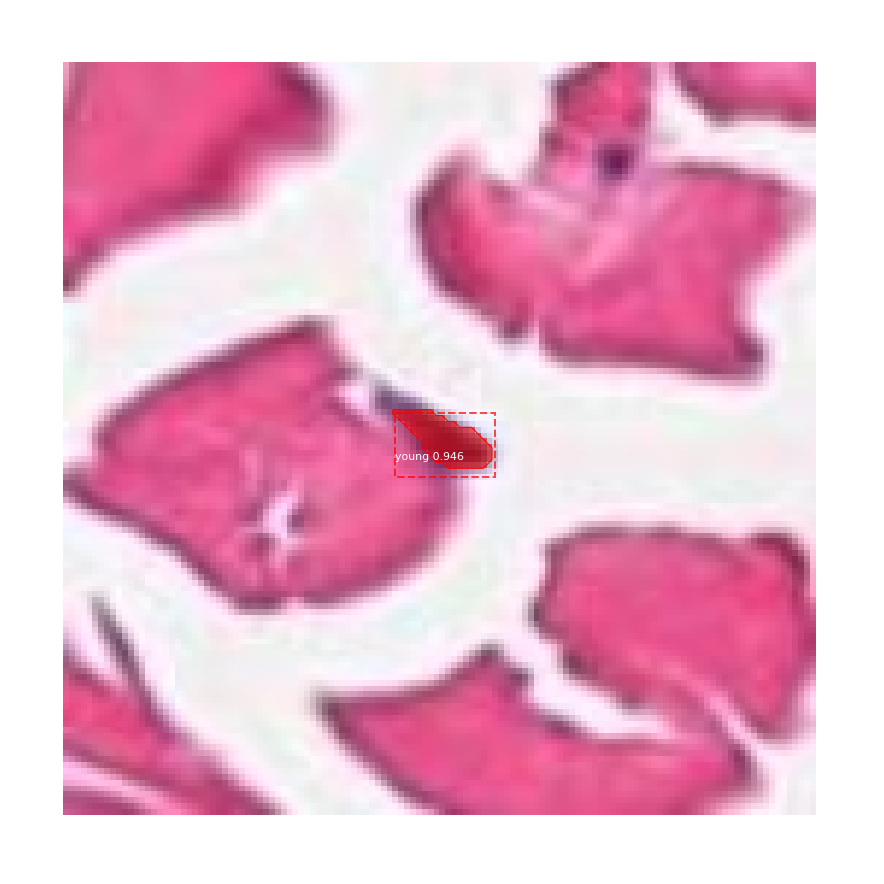

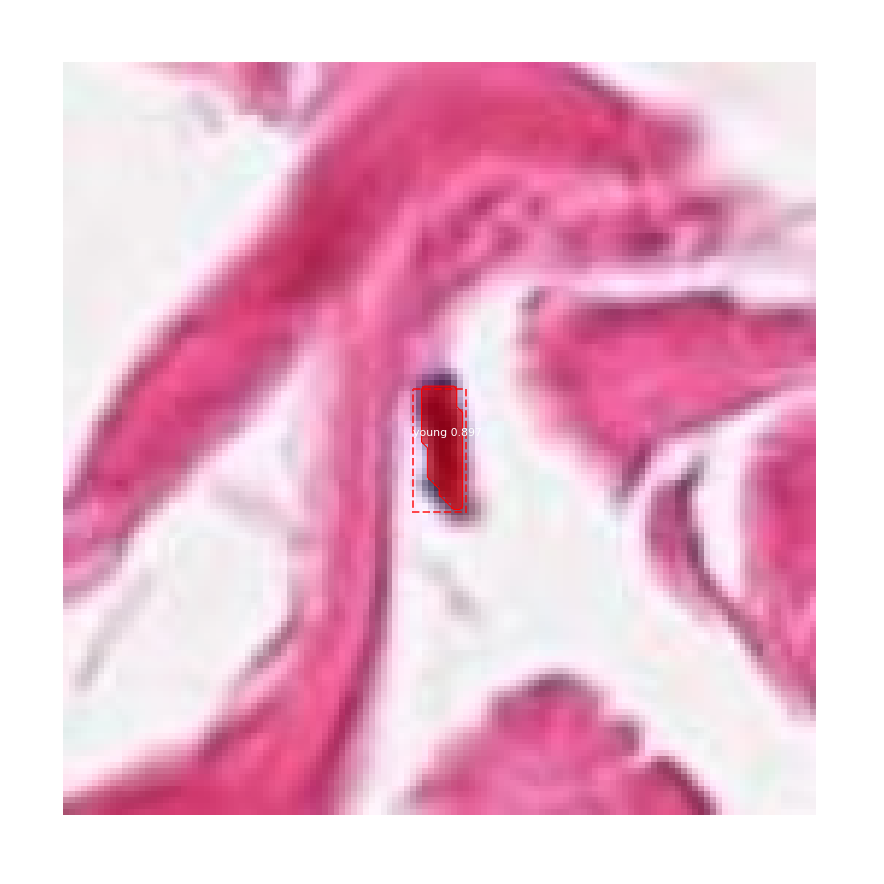

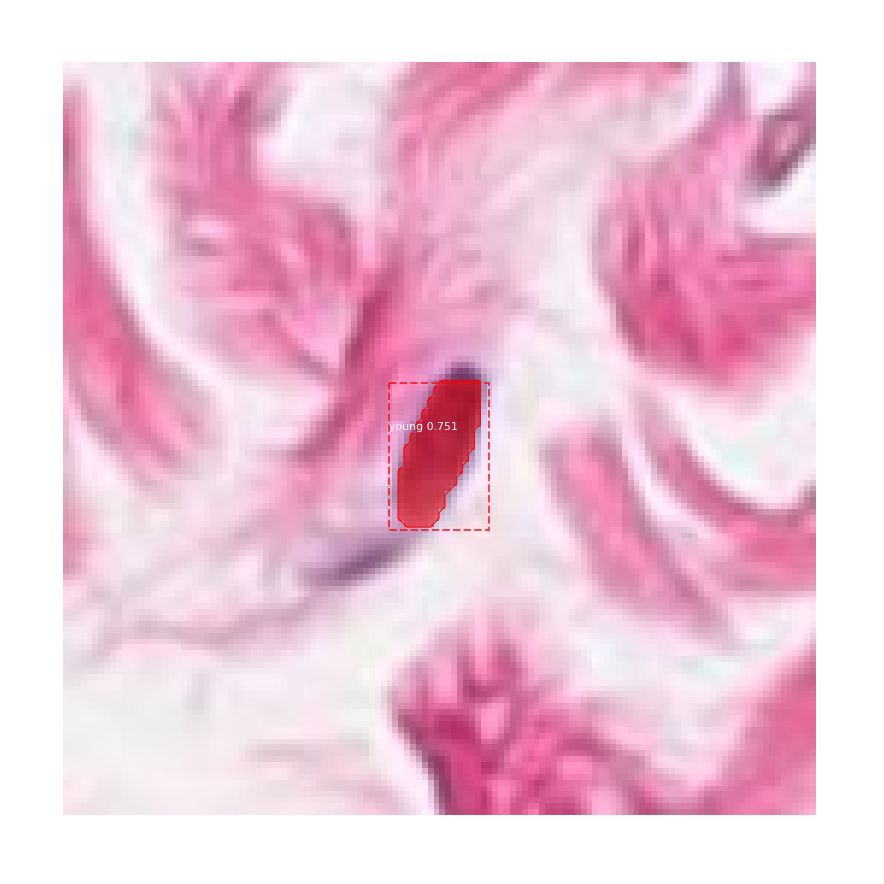

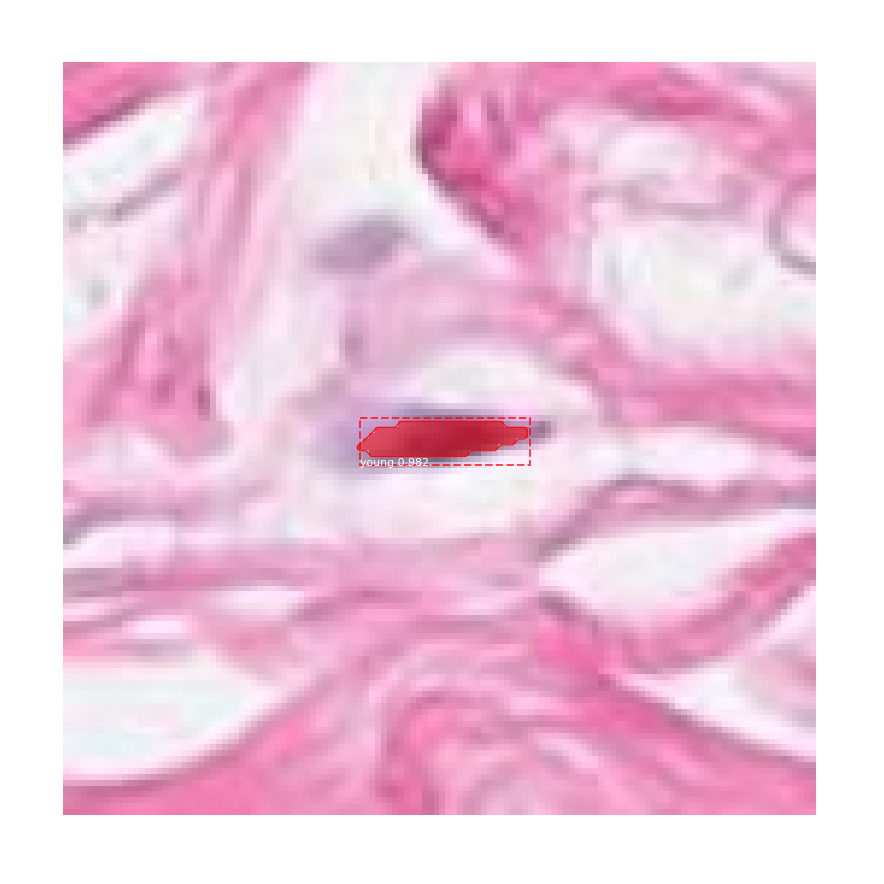

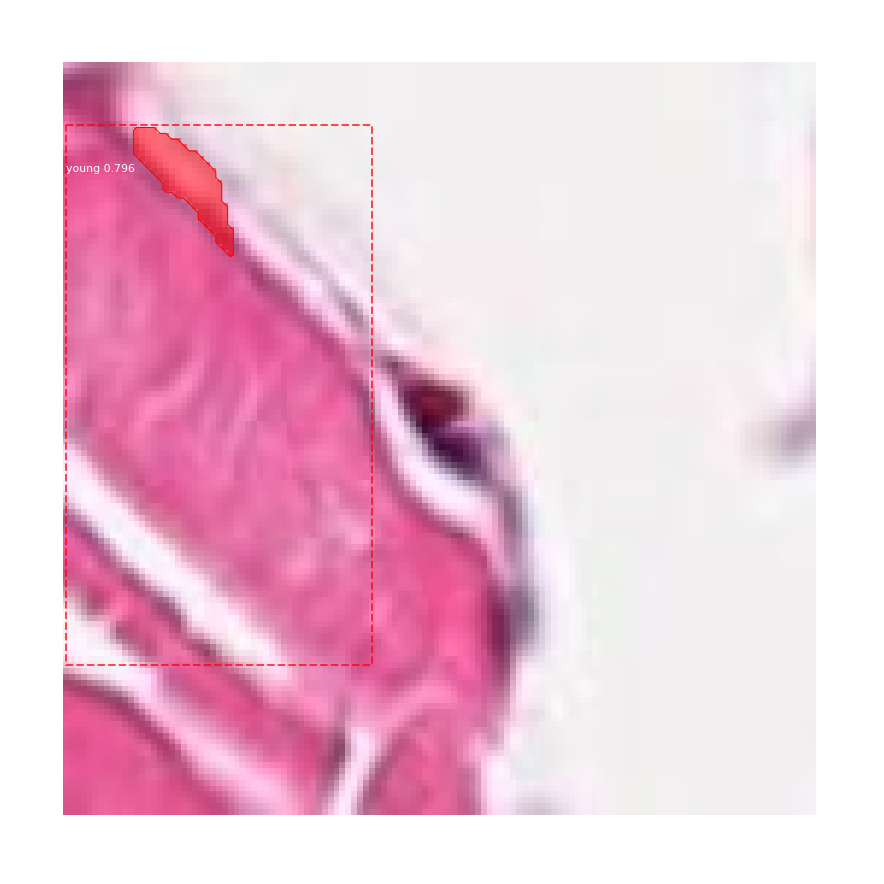

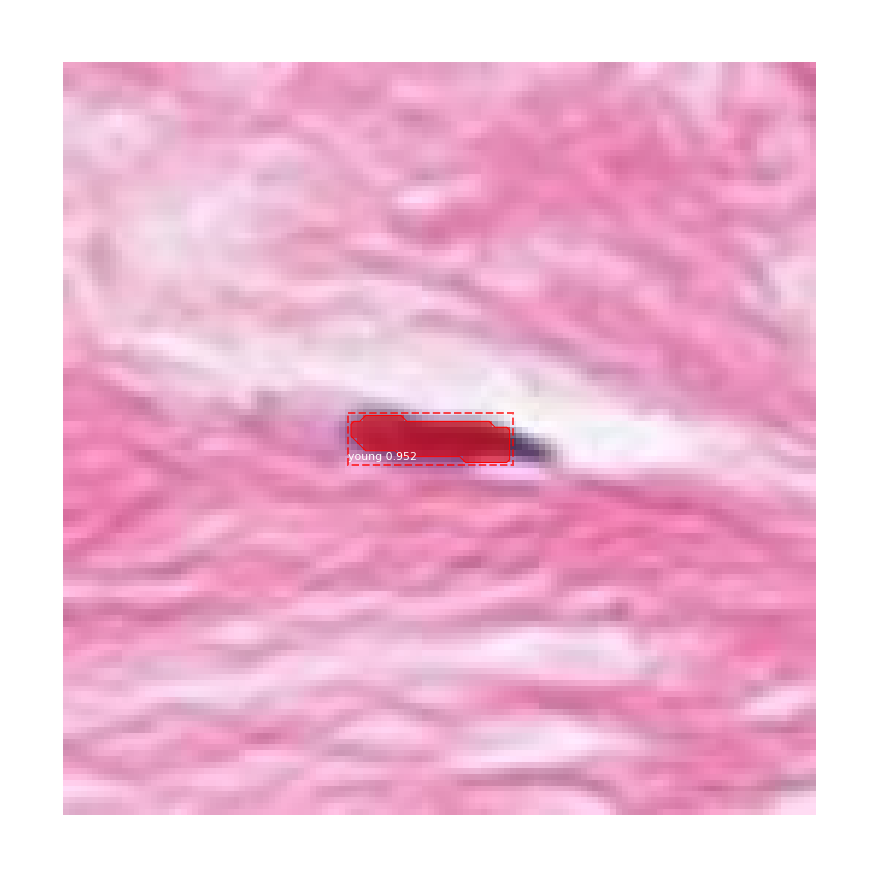

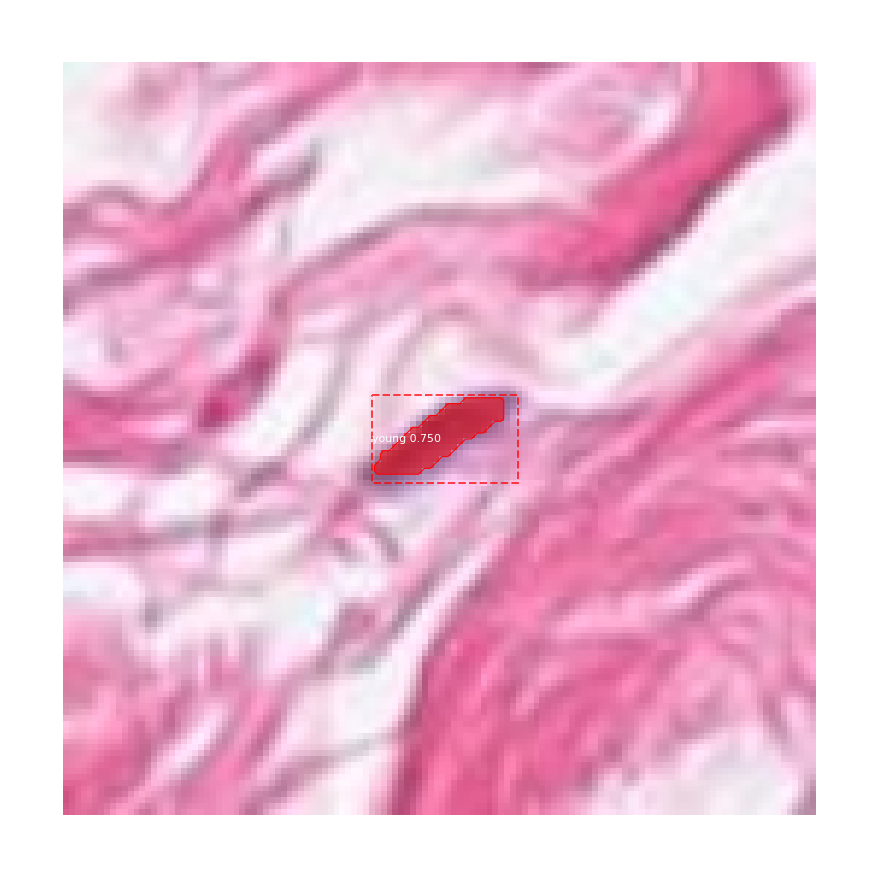

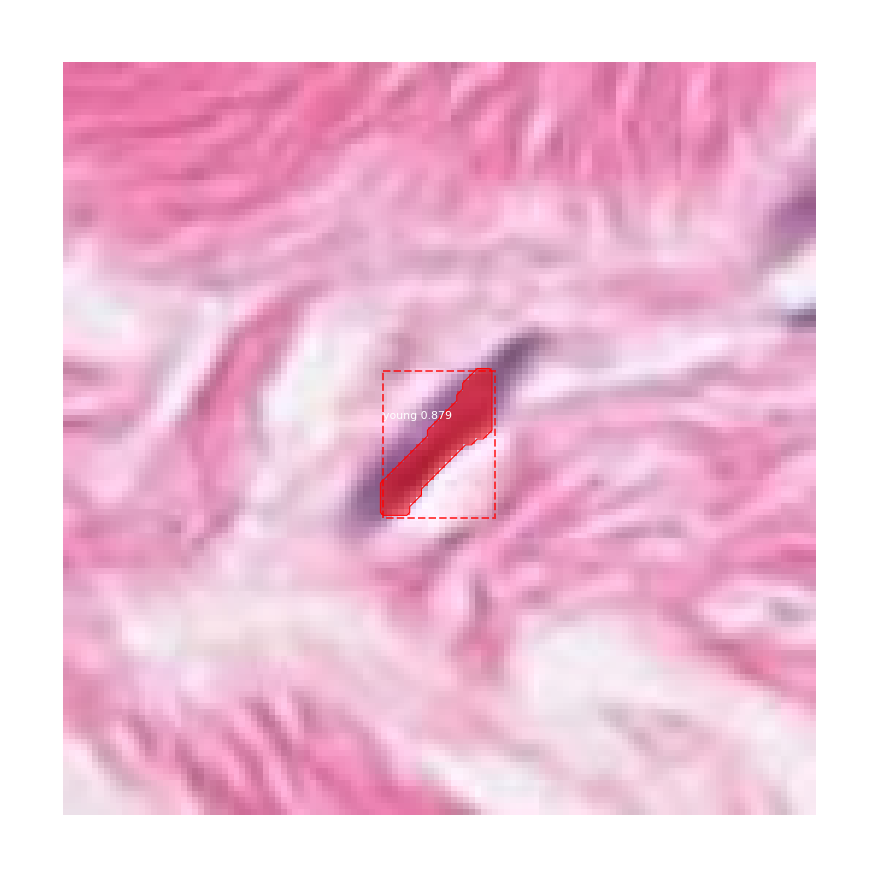

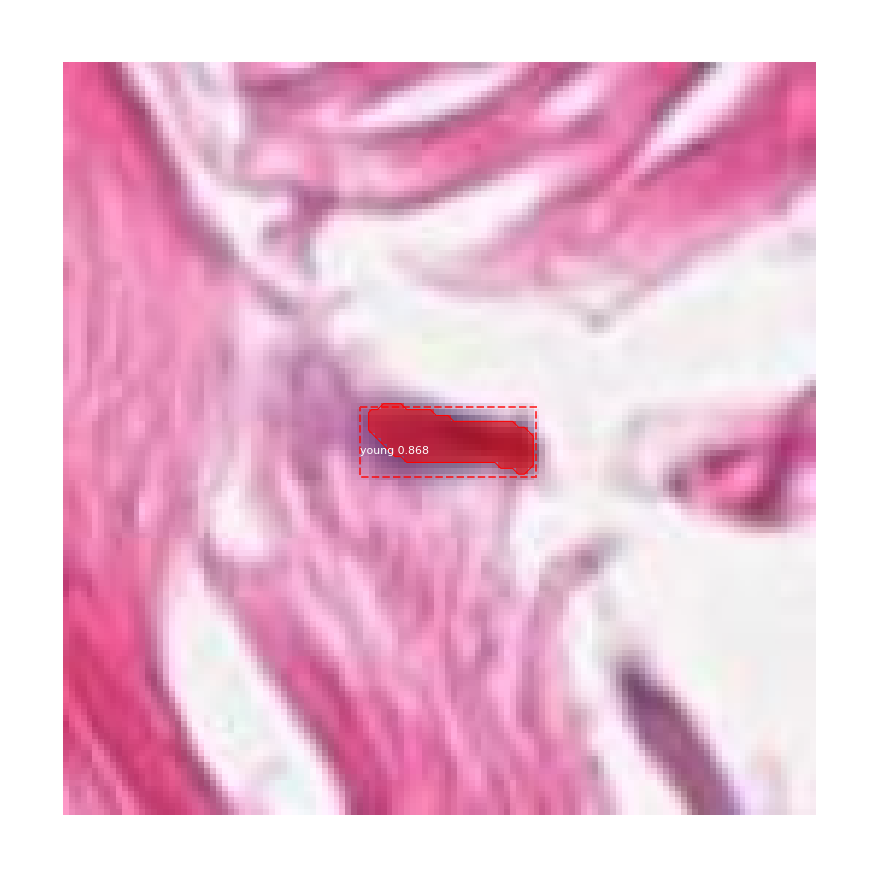

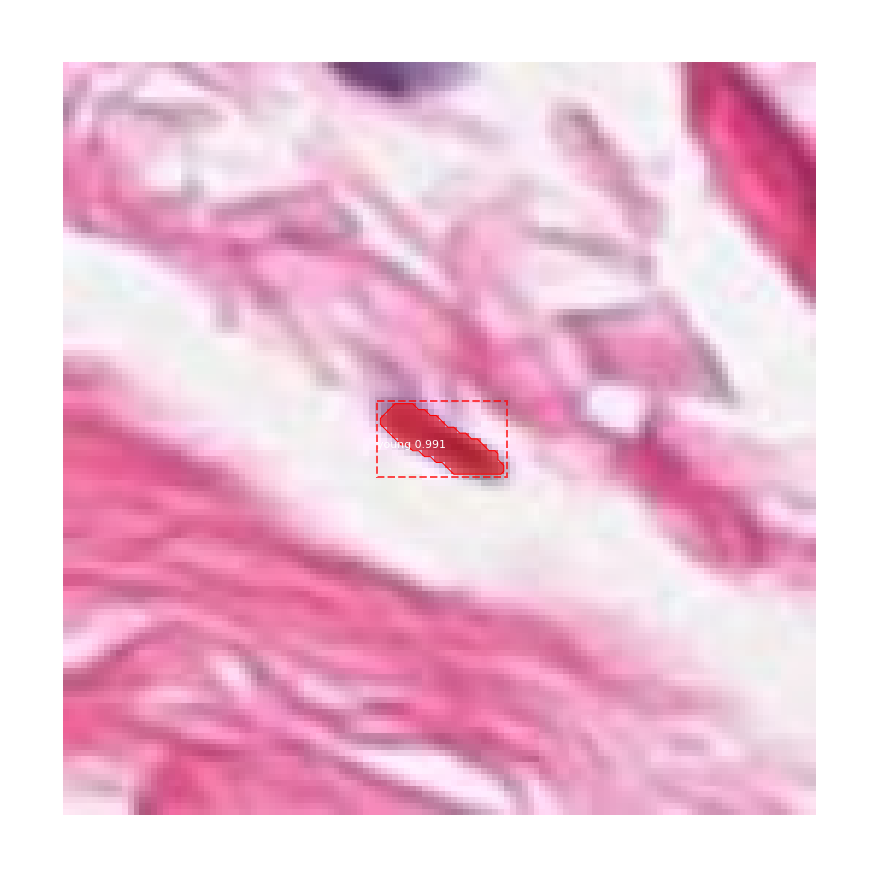

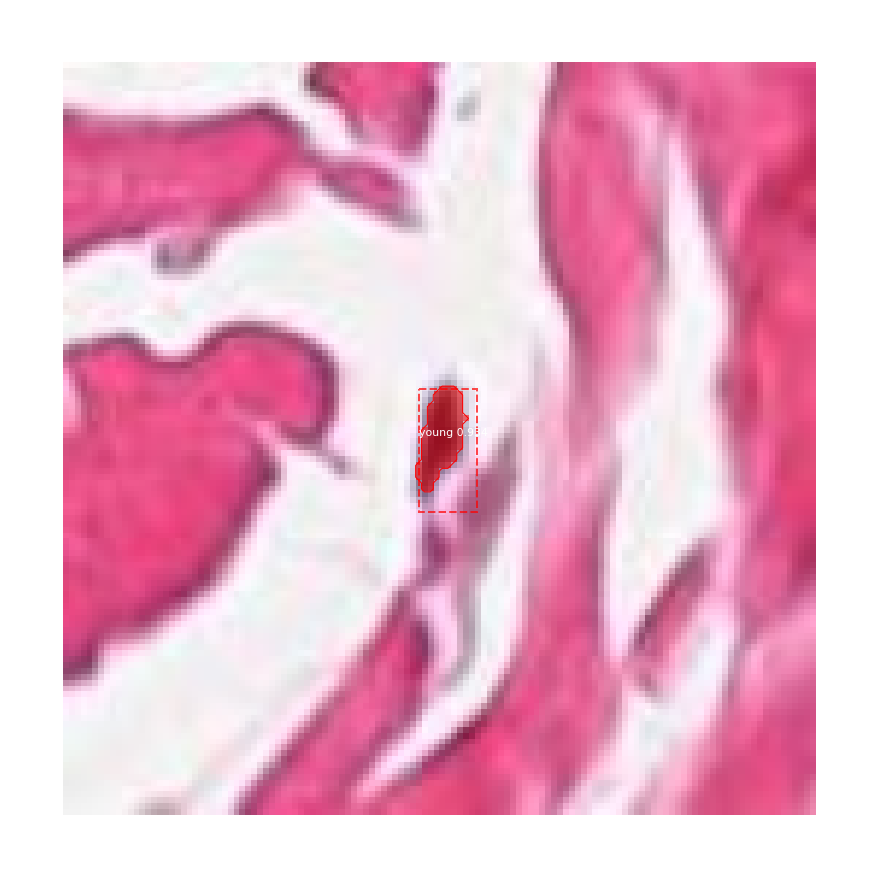

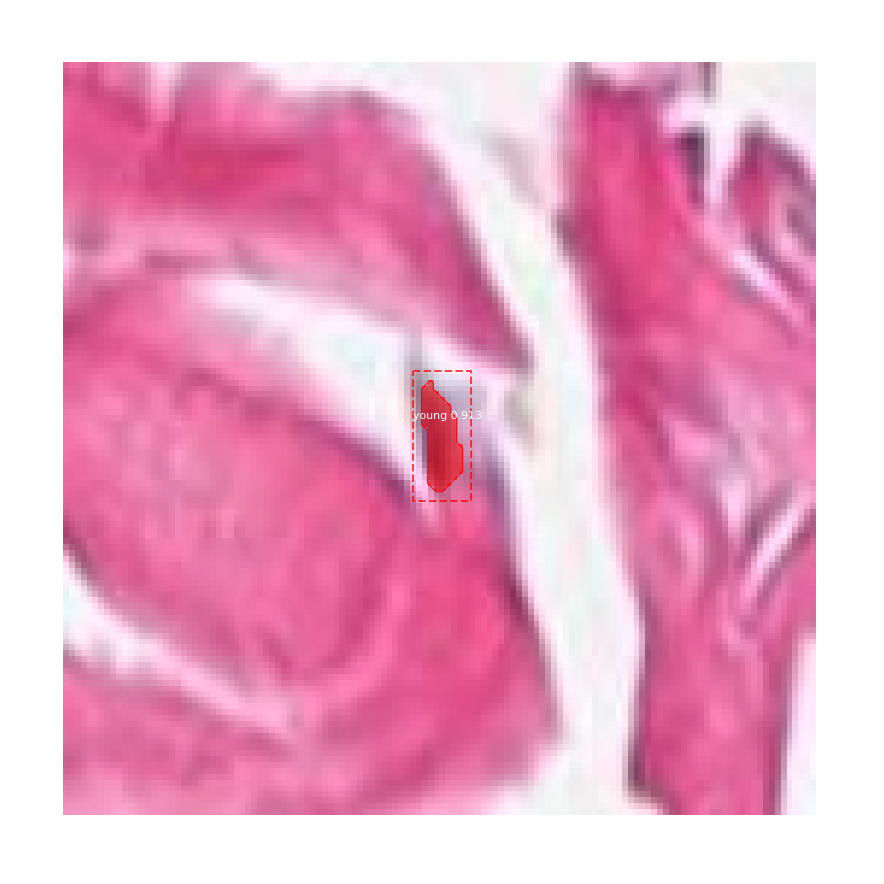

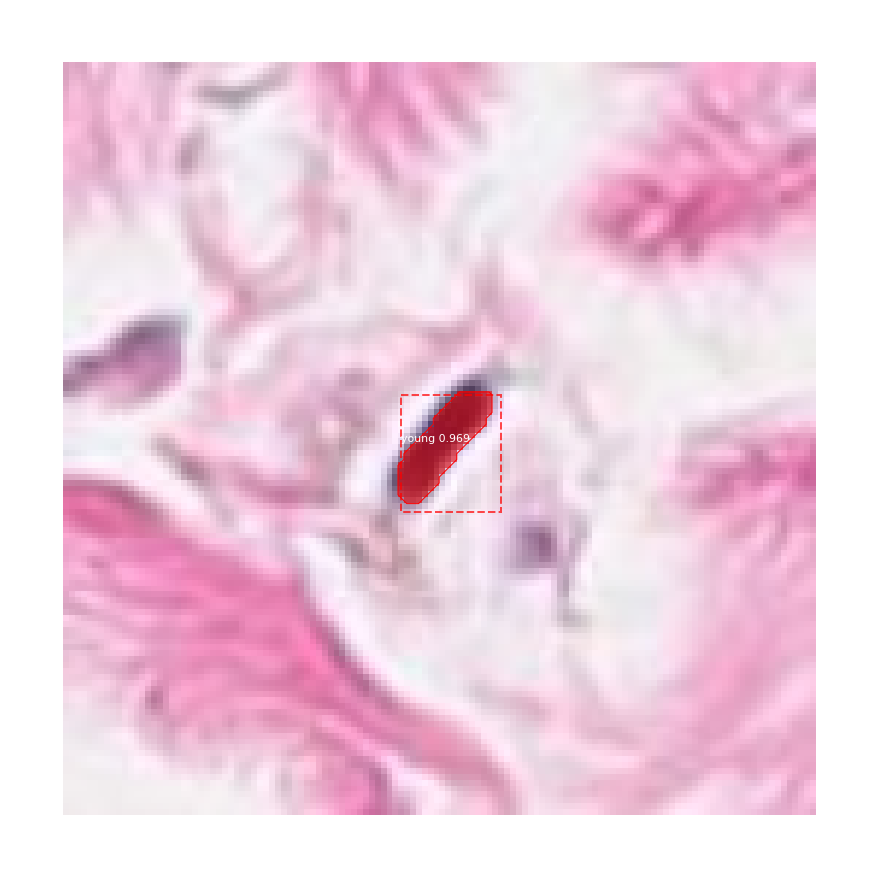

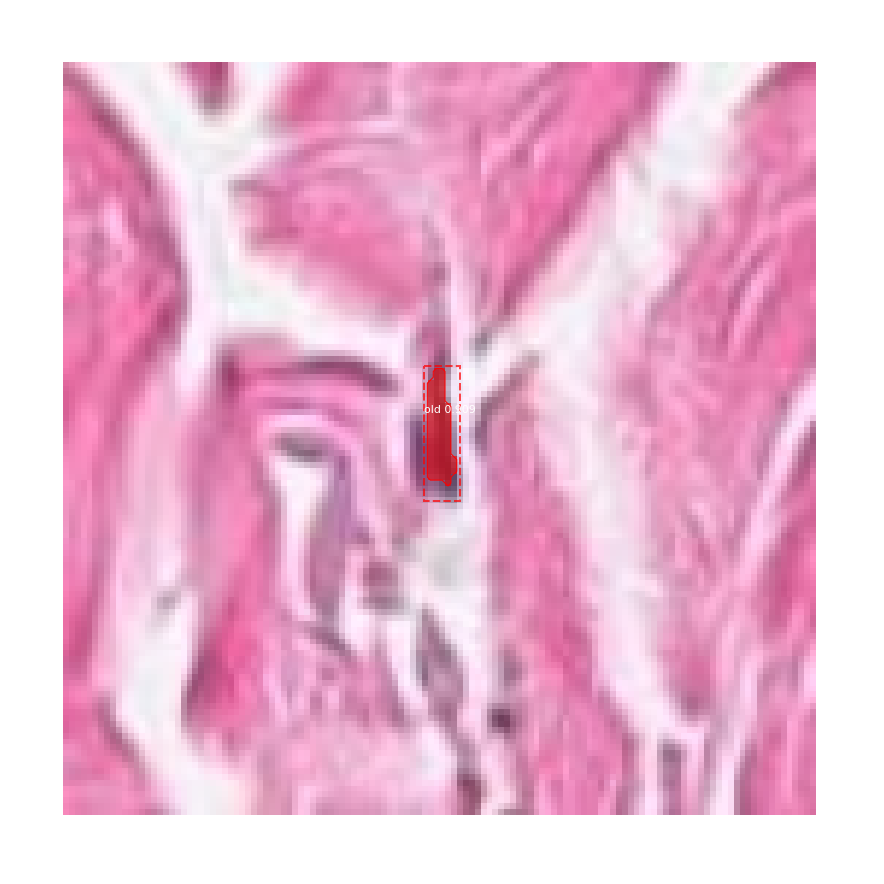

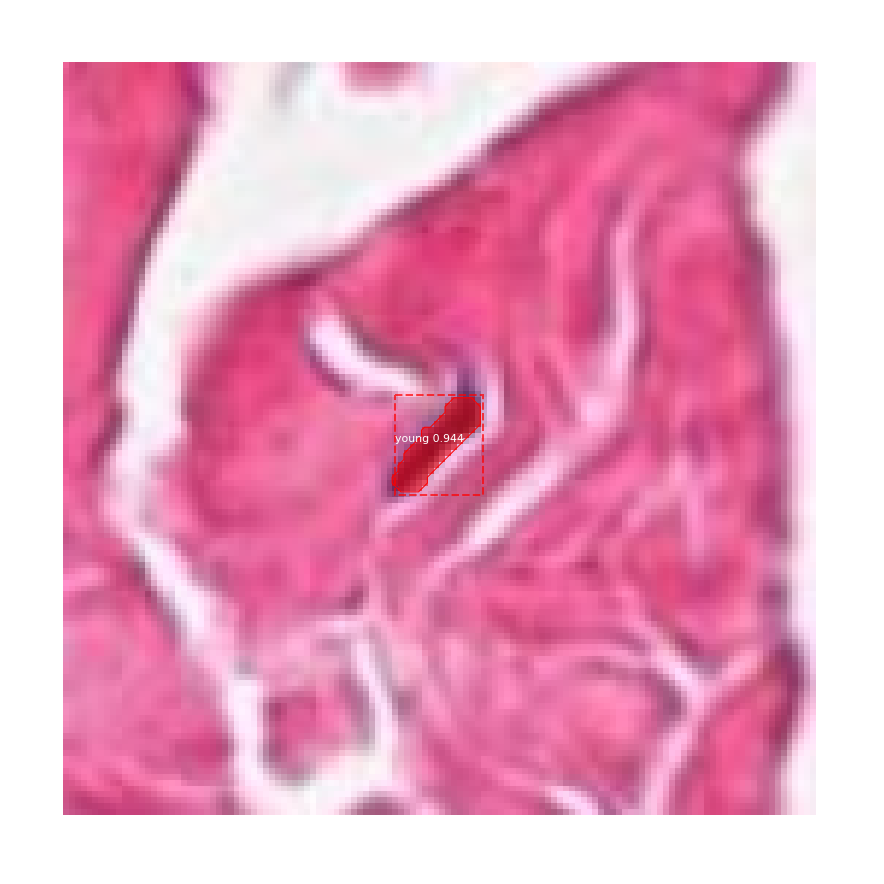

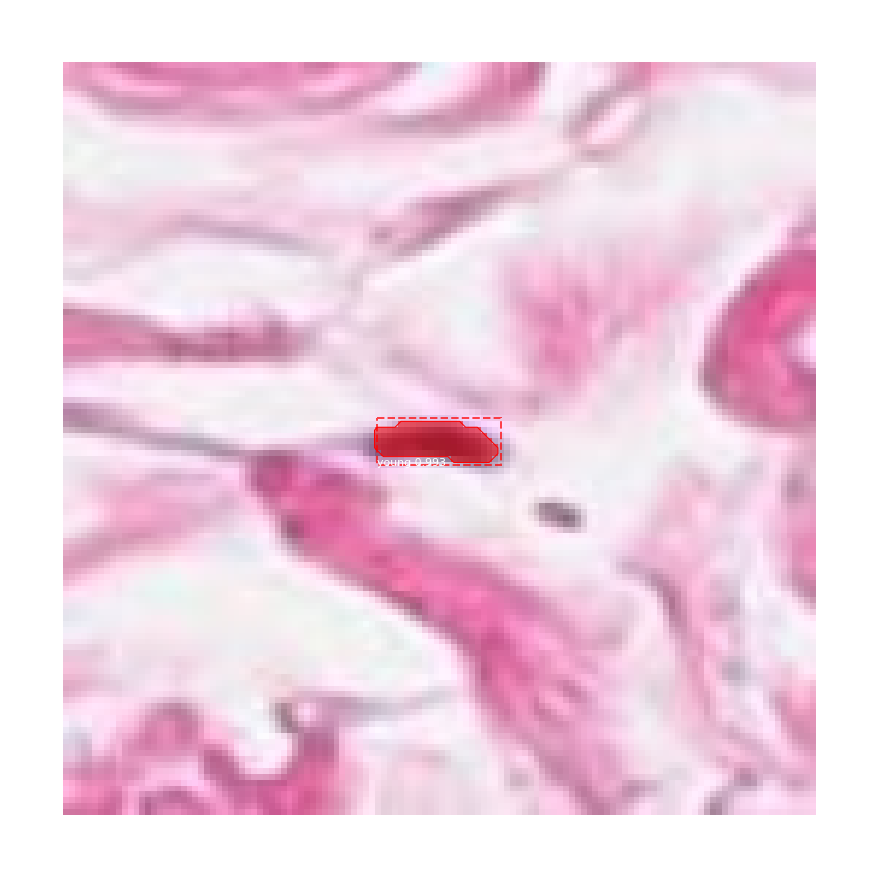

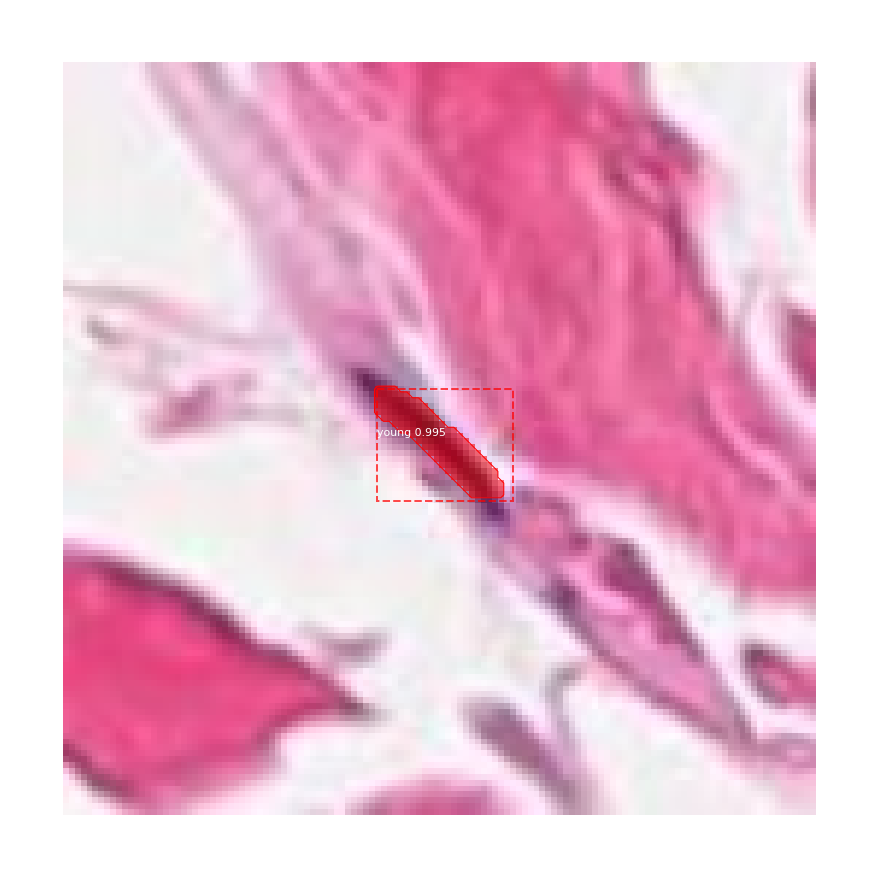

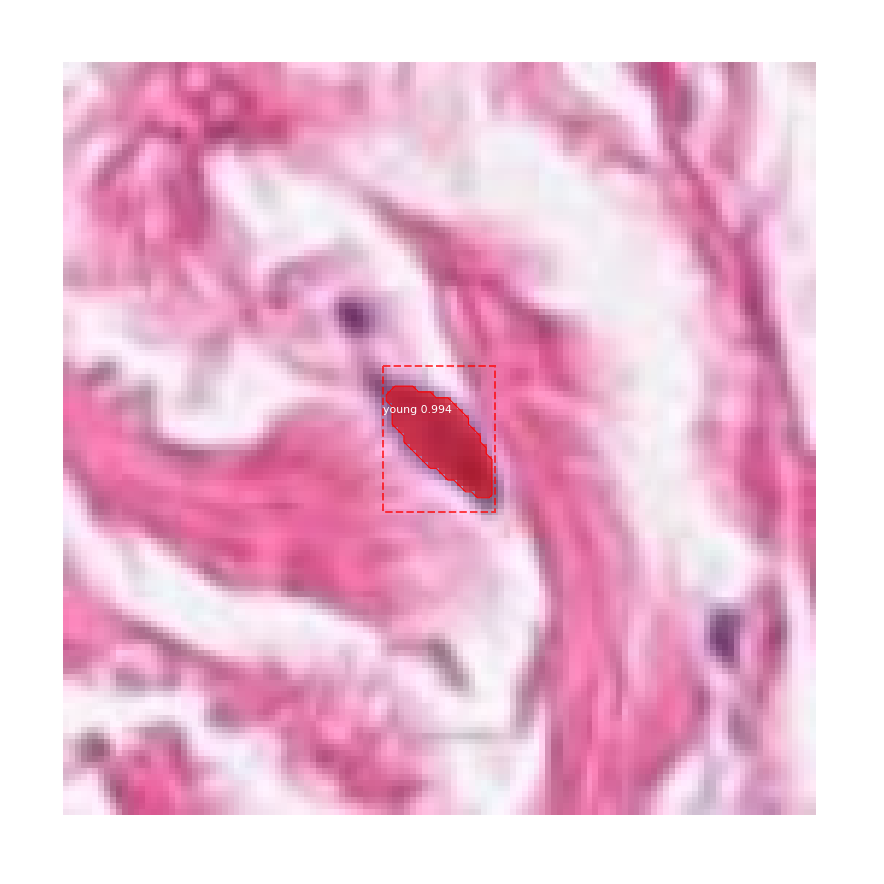

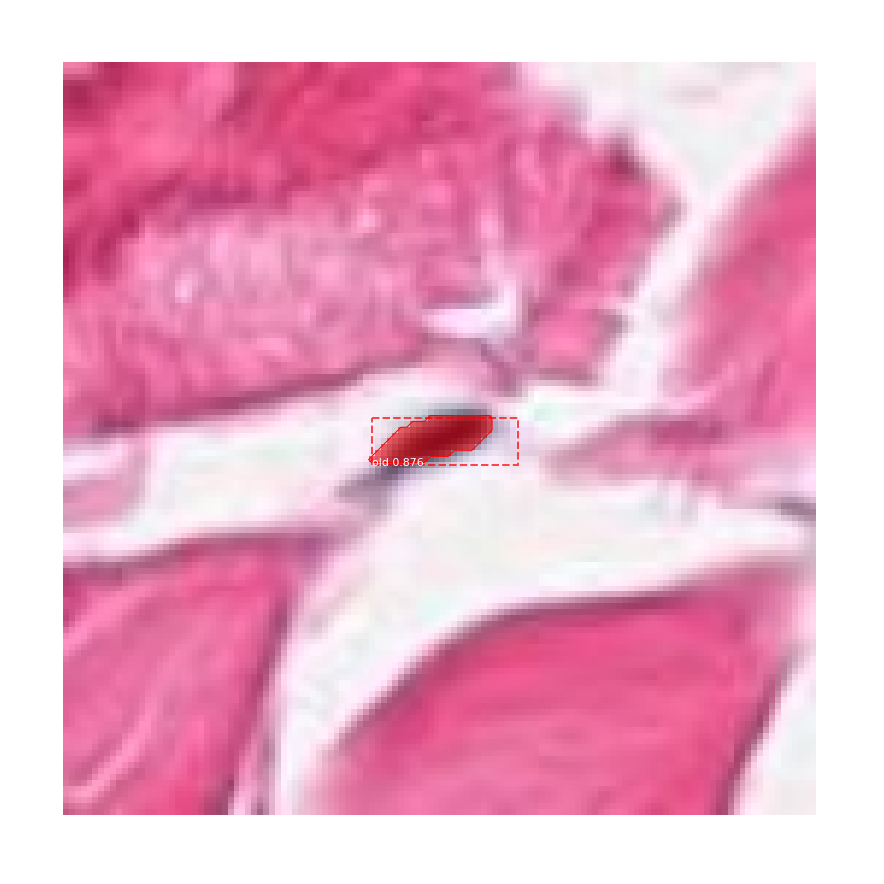

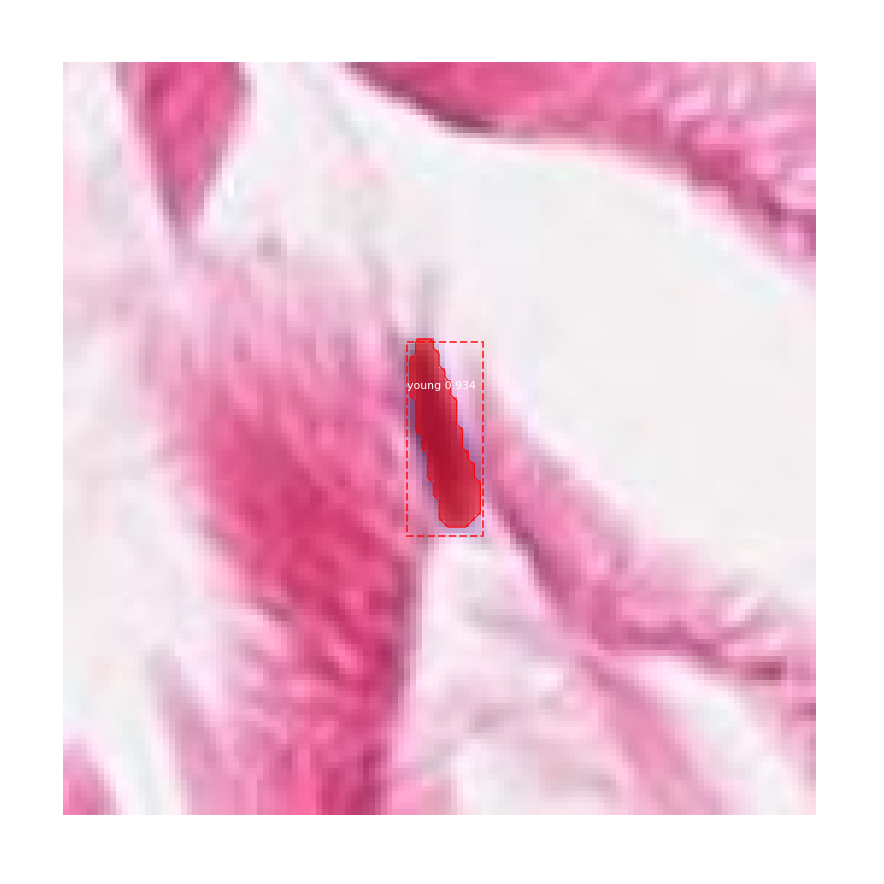

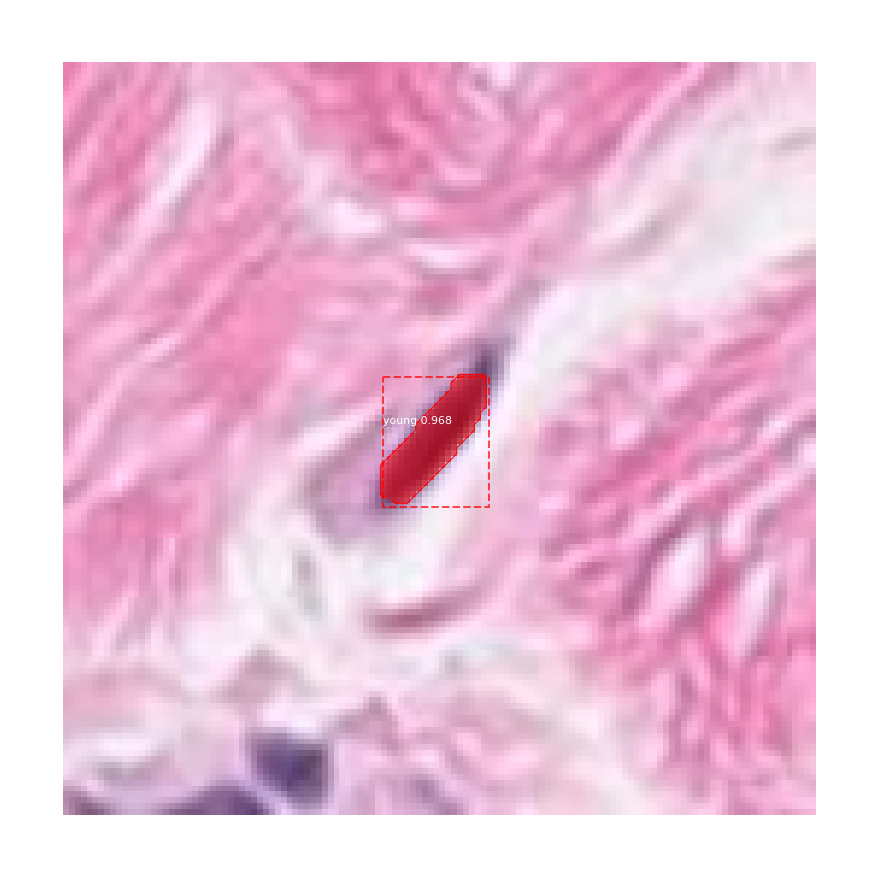

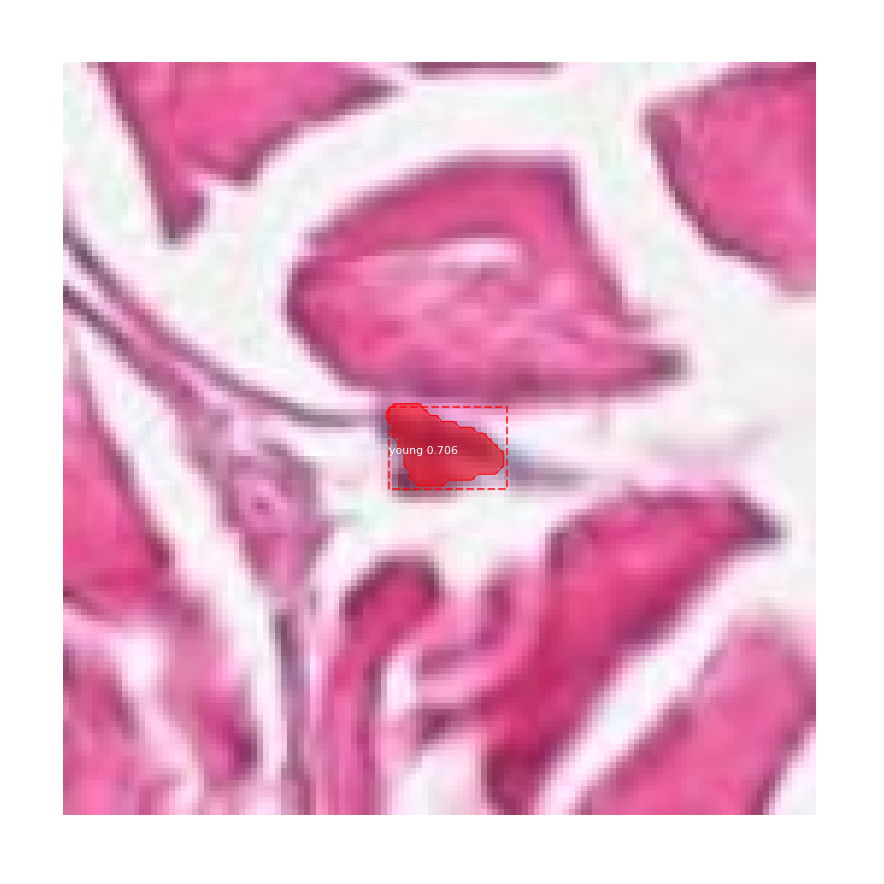

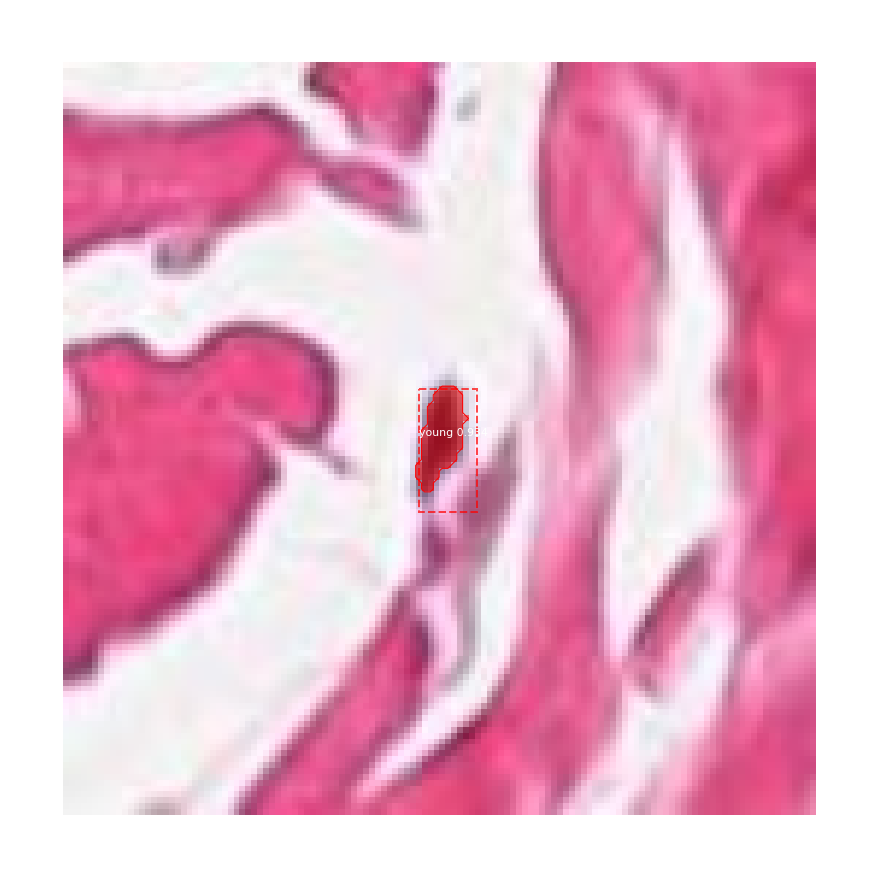

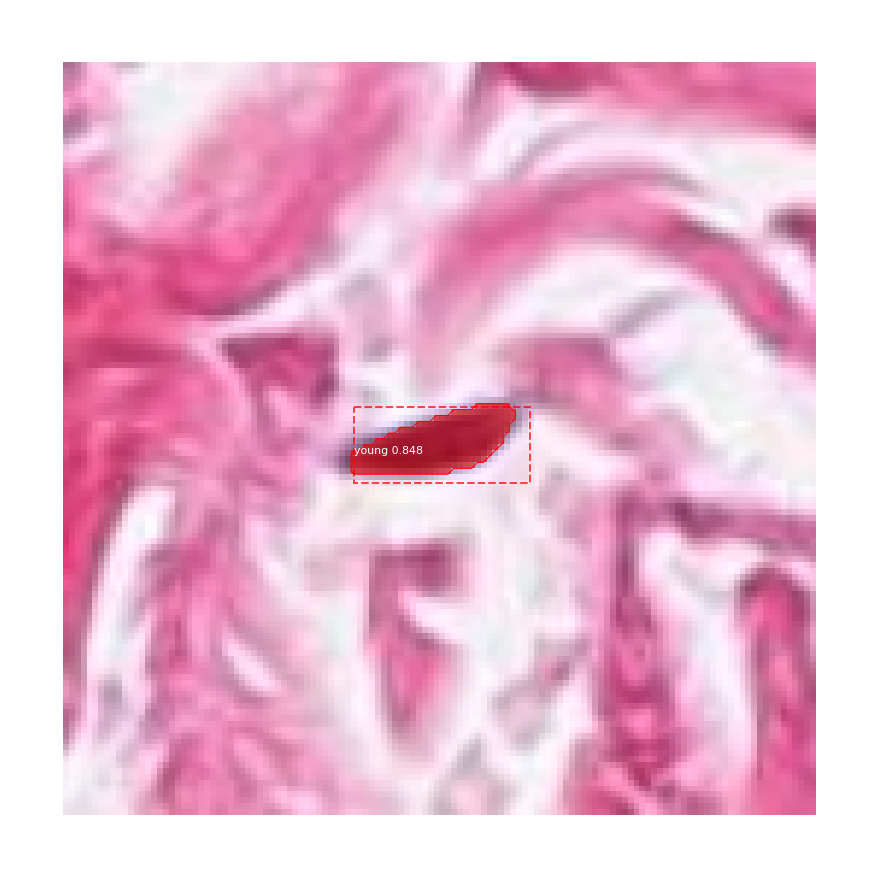

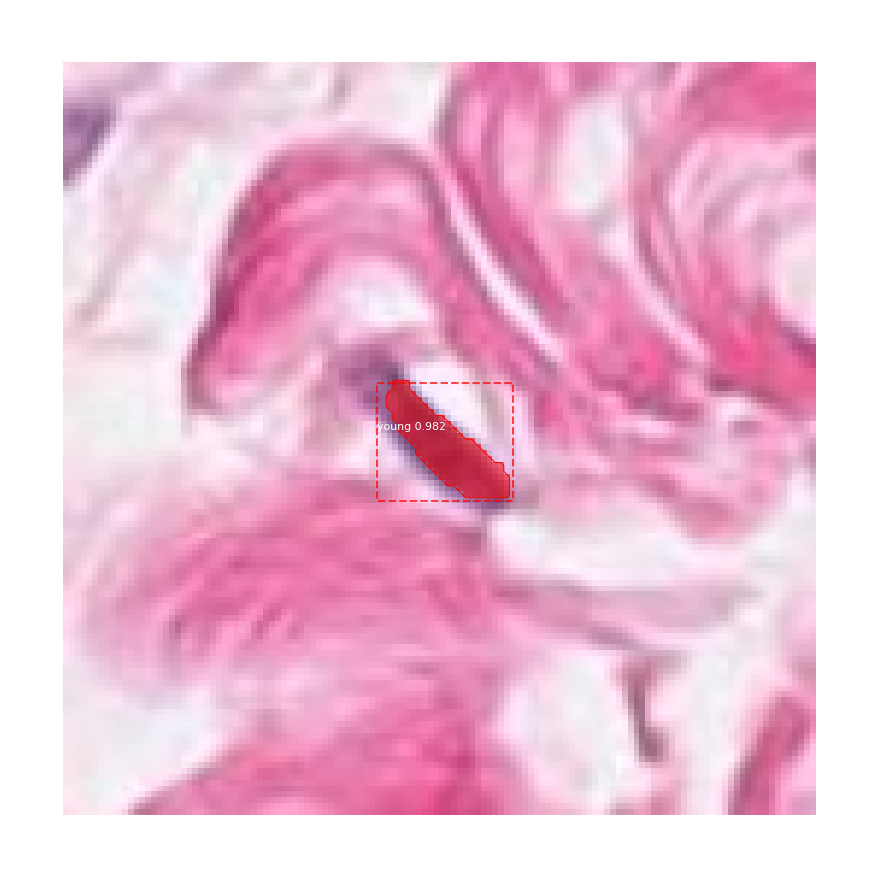

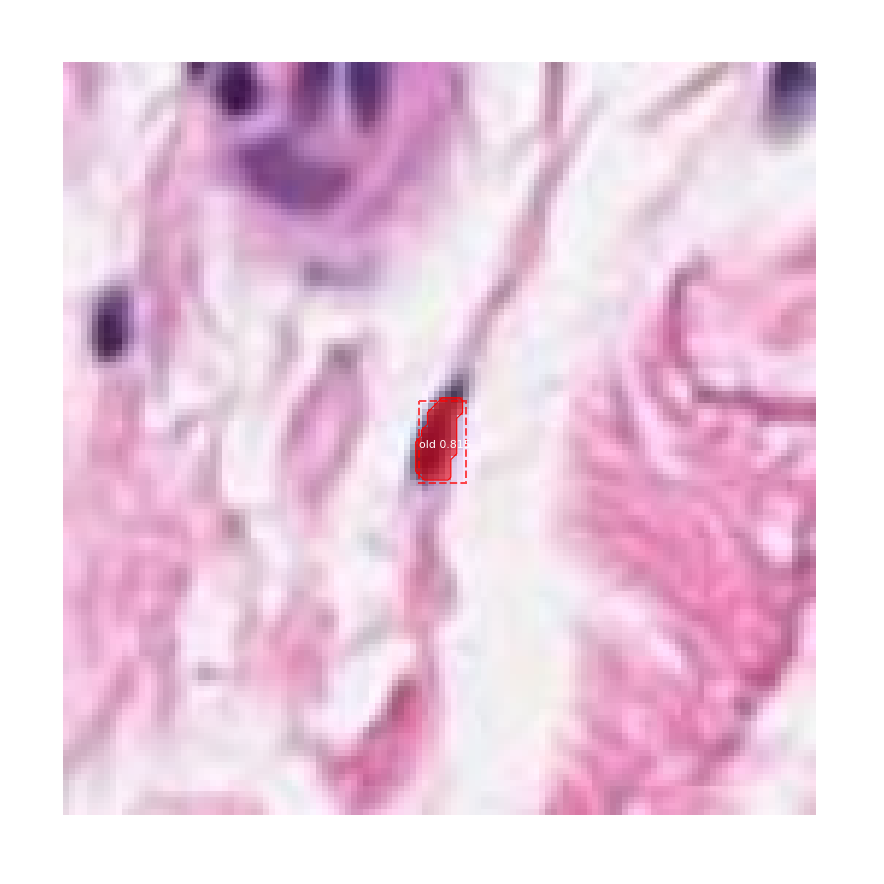

In [1]:
import os
import sys
import numpy as np
import random
import cv2
import pathlib
import matplotlib.pyplot as plt
import skimage

from skimage.filters import threshold_otsu
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn import utils
from mrcnn.config import Config

class ShapesConfig(Config):
    # Give the configuration a recognizable name
    NAME = "fibroblast"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    NUM_CLASSES = 1 + 2  # background + 2 young and old
    IMAGE_MIN_DIM = 10
    IMAGE_MAX_DIM = 128
    RPN_ANCHOR_SCALES = (2, 4, 8, 16, 32)  # anchor side in pixels
    TRAIN_ROIS_PER_IMAGE = 8
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 5
    LEARNING_RATE = 0.001
config = ShapesConfig()

class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_MAX_DIM = 128
inference_config = InferenceConfig()

def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class ShapesDataset(utils.Dataset):
    def list_images(self,data_dir):
        # Add classes
        self.add_class("fibroblast",1,CLASS_NAMES[0])
        self.add_class("fibroblast",2,CLASS_NAMES[1])
        train_images = list(data_dir.glob('*\*\image\*.jpg'))

        # Add images
        for idx,train_image in enumerate(train_images):
            ground = os.path.normpath(train_image).split(os.path.sep)[-4]
            self.add_image("fibroblast",image_id=idx,path=train_image,truth=ground,
                           height=config.IMAGE_SHAPE[0],width=config.IMAGE_SHAPE[1])

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        info = self.image_info[image_id]
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            print('grayscale to rgb')
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            print('rgba to rgb')
            image = image[..., :3]
        image = cv2.resize(image,dsize=(128,128))
        return image

    def load_mask(self, image_id):
        # Load binary mask
        info = self.image_info[image_id]
        impath = info['path']
        maskpath = pathlib.Path(str(impath).replace("image", "label"))
        instancenum = 1
        mask = np.zeros([info['height'], info['width'], instancenum], dtype=np.uint8)
        label = info['truth']
        # 0 is background
        labelidx = np.argwhere(CLASS_NAMES == label).flat[0]+1
        masklayer = skimage.io.imread(maskpath)
        masklayer = cv2.resize(masklayer,dsize=(128,128))
        thresh = threshold_otsu(masklayer)
        binary = masklayer > thresh
        mask[:, :, 0] = binary
        class_ids = np.array([labelidx])
        return mask.astype(np.bool), class_ids.astype(np.int32)

data_dir = pathlib.Path(r'C:\Users\kuki\OneDrive - Johns Hopkins\Research\Skin\RCNN data\RCNNtrain')
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_store"])
print(CLASS_NAMES)

dataset_train = ShapesDataset()
dataset_train.list_images(data_dir)
dataset_train.prepare()

data_dir_val = pathlib.Path(r'C:\Users\kuki\OneDrive - Johns Hopkins\Research\Skin\RCNN data\RCNNtest')
dataset_val = ShapesDataset()
dataset_val.list_images(data_dir_val)
dataset_val.prepare()

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask, masksizes =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, sixth=True)


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))

gt_mask2 = skimage.morphology.binary_opening(gt_mask)
visualize.display_instances(original_image, gt_bbox, gt_mask2, gt_class_id,
                            dataset_train.class_names, figsize=(8, 8))


results = model.detect([original_image], verbose=1)
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'])

rr2 = skimage.morphology.binary_opening(r['masks'])
visualize.display_instances(original_image, r['rois'], rr2, r['class_ids'],
                            dataset_val.class_names, r['scores'])

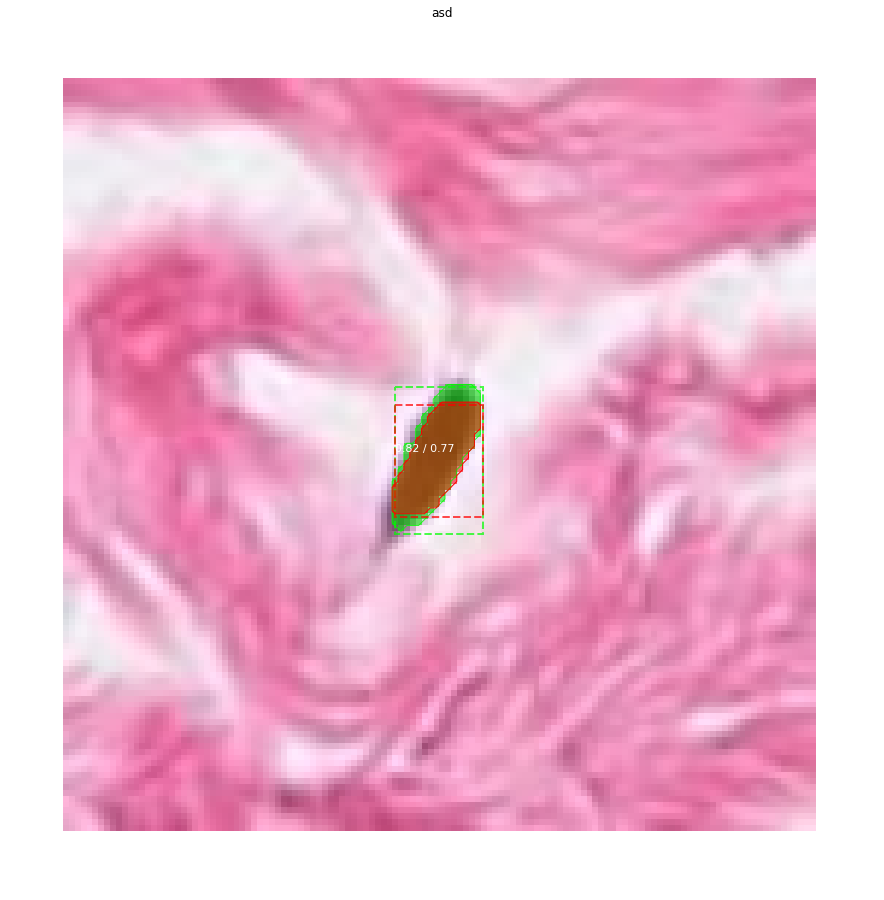

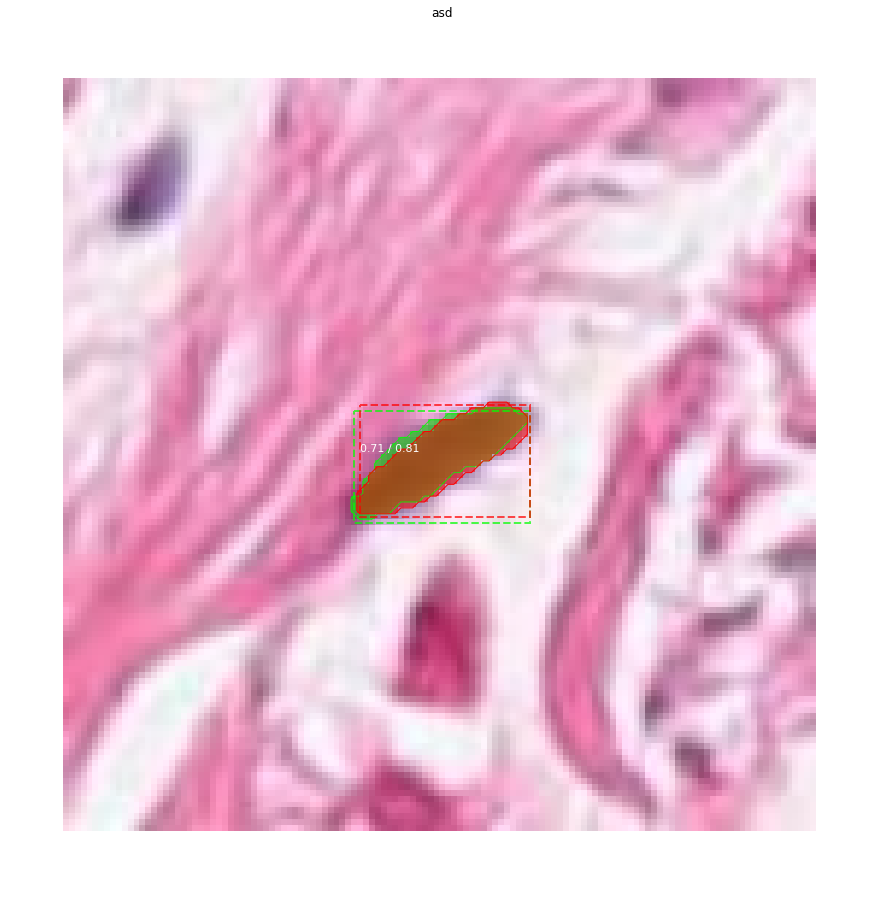

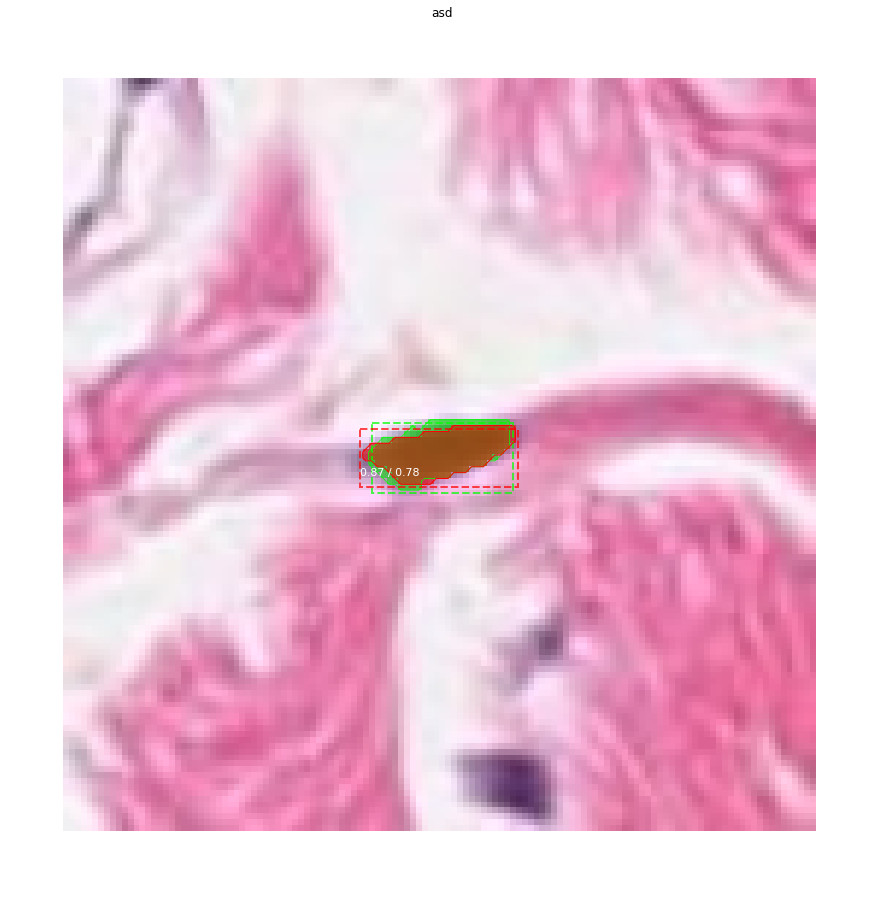

In [25]:
image_ids = np.random.choice(dataset_val.image_ids, 3)
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    # molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    results = model.detect([image], verbose=0)
    r = results[0]
    if len(r['class_ids'])<1 :
        print('nothing detected')
        continue
    # visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
    #                             dataset_val.class_names, r['scores'])
    visualize.display_differences(image,
                        gt_bbox, gt_class_id, gt_mask,
                         r['rois'],  r['class_ids'], r['scores'], r['masks'],
                        dataset_val.class_names, title="asd", ax=None,
                        show_mask=True, show_box=True,
                        iou_threshold=0.5, score_threshold=0.5)

In [18]:
import timeit

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 1200)
APs = []
APs_open = []
ovl =[]
print(len(image_ids))
def myfunc():
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        # molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        if len(r['class_ids'])<1 :
            # print('nothing detected')
            continue
        # r_open = skimage.morphology.binary_opening(r['masks'])
        # visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
        #                             dataset_val.class_names, r['scores'])
        # Compute AP
        # AP, precisions, recalls, overlaps =\
        #     utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
        #                      r["rois"], r["class_ids"], r["scores"], r['masks'])


        # AP_open, precisions2, recalls2, overlaps2 = \
        #     utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
        #                      r["rois"], r["class_ids"], r["scores"], r_open)
        # APs.append(AP)
        # APs_open.append(AP_open)
        # ovl.append(overlaps)
print(timeit.timeit(myfunc,number=1))
#15sec for 300
#30sec for 600
#60sec for 1200

1200
60.70021020000013


In [23]:
from joblib import Parallel, delayed
import time
image_ids = np.random.choice(dataset_val.image_ids, 600)
def myfunc():
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    results = model.detect([image], verbose=0)
    r = results[0]
    return r
    # if len(r['class_ids'])<1 : continue

start = time.time()
# r = Parallel(n_jobs=-1)(delayed(myfunc)() for image_id in image_ids)
for image_id in image_ids:
    myfunc()
end = time.time()
print('For myfunc, elapsed time is ' + str(end - start) + 'seconds...')

For parallel of bdreg, elapsed time is 30.101574420928955seconds...


In [14]:
#Compute Average Precision at a set IoU threshold
print("mAP: ", np.mean(APs))
print("mAP: ", np.mean(APs_open))
print("overlaps: ", np.mean(ovl))


UsageError: Line magic function `%%timeit` not found.
